In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
def run_single_coin_backtest(
    csv_path: str,
    ticker: str,
    notional_usd: float = 200_000,
    sma_fast: int = 30,
    sma_slow: int = 70,
    entropy_window: int = 20,
    entropy_percentile: float = 0.8,
    atr_mult: float = 2,
    max_bars: int = 3,
    ofi_z_thresh: float = 0.5,
    vol_surge_percentile: float = 0.6,
    opening_range_bars: int = 4,
    mean_rev_zscore_thresh: float = 1.5,
    active_hours: set = None,
    use_fixed_sl: bool = True
):
    """
    Reads a 1-minute CSV from Binance, resamples to 15-minute bars, computes indicators,
    runs the strategy with a fixed notional, and returns:
      • coin_15m: DataFrame of 15-minute bars (with strategy_returns_pct, market_returns, etc.)
      • trade_log: DataFrame of all closed trades for this ticker
      • daily_returns_pct: Series of daily % returns of the strategy
      • market_daily_returns: Series of daily % returns for buy-&-hold
    """
    
    
    # 1) Load the CSV and set up a 1-minute DataFrame
    df_1m = pd.read_csv(csv_path)
    # 1) Load the CSV and set up a 1-minute DataFrame
    df_1m = pd.read_csv(csv_path)

# --- Auto-detect time column: prefer 'open_time' if available, else 'timestamp' ---
    time_col = None
    if 'open_time' in df_1m.columns:
        time_col = 'open_time'
    elif 'timestamp' in df_1m.columns:
        time_col = 'timestamp'
    else:
        raise ValueError(f"No suitable time column found in {csv_path}")

    df_1m['open_time'] = pd.to_datetime(df_1m[time_col])
    df_1m = df_1m.set_index('open_time')

    
    # --- FILTER OUT ALL DATA BEFORE 2020-01-01 ---
    df_1m = df_1m.loc["2020-01-01":]

    # 2) Resample to 15-minute bars
    coin_15m = df_1m.resample("15min").agg({
        "open":   "first",
        "high":   "max",
        "low":    "min",
        "close":  "last",
        "volume": "sum"
    }).dropna().reset_index()

    # 3) Prepare index and helper columns
    coin_15m["open_time"] = pd.to_datetime(coin_15m["open_time"])
    coin_15m = coin_15m.set_index("open_time").copy()
    coin_15m["hour"] = coin_15m.index.hour
    coin_15m["date"] = coin_15m.index.date

    # 4) Compute static indicators (ATR, vol_of_vol, OFI, momentum, vol_pct, NR4)
    def precompute_static_indicators(df):
        df = df.copy()
        df["tr"] = np.maximum(
            df["high"] - df["low"],
            np.maximum(
                (df["high"] - df["close"].shift(1)).abs(),
                (df["low"]  - df["close"].shift(1)).abs()
            )
        )
        df["atr"] = df["tr"].rolling(14).mean()

        df["vol_of_vol"] = df["atr"].rolling(20).std()
        df["vol_of_vol_thresh"] = df["vol_of_vol"].rolling(100).quantile(0.7)

        # Order Flow Imbalance (OFI)
        ofi_raw = (df["close"] - df["open"]) + (df["close"] - df["low"]) - (df["high"] - df["close"])
        df["ofi"] = pd.Series(ofi_raw).rolling(5).mean()
        df["ofi_z_mean"] = df["ofi"].rolling(10).mean()
        df["ofi_z_std"] = df["ofi"].rolling(10).std()
        df["ofi_z"] = (df["ofi"] - df["ofi_z_mean"]) / df["ofi_z_std"]

        # 3-period momentum
        df["momentum3"] = df["close"].pct_change(3)

        # Volume percentile (last bar’s rank in rolling 50)
        df["vol_pct"] = df["volume"].rolling(50).apply(
            lambda x: pd.Series(x).rank(pct=True).iloc[-1]
        )

        # NR4 (narrow range: current range = min of last 4 ranges)
        df["range"] = df["high"] - df["low"]
        # Use x[-1] because rolling(..., raw=True) passes a NumPy array
        df["is_NR4"] = df["range"].rolling(4).apply(lambda x: x[-1] == x.min(), raw=True)

        df = df.dropna()
        return df

    coin_15m = precompute_static_indicators(coin_15m)

    # 5) Compute rolling SMAs, VWAP, entropy, ORB, mean reversion
    coin_15m["sma_fast"] = coin_15m["close"].rolling(sma_fast).mean()
    coin_15m["sma_slow"] = coin_15m["close"].rolling(sma_slow).mean()
    coin_15m["sma_fast_slope"] = coin_15m["sma_fast"].diff(5)
    coin_15m["trend_up"]   = coin_15m["sma_fast_slope"] > 0
    coin_15m["trend_down"] = coin_15m["sma_fast_slope"] < 0

    coin_15m["vwap"] = (
        (coin_15m["close"] * coin_15m["volume"]).rolling(15).sum()
        / coin_15m["volume"].rolling(15).sum()
    )

    def calculate_entropy(arr, window, bins=10):
        ent = [np.nan] * len(arr)
        for idx in range(len(arr)):
            if idx < window:
                continue
            slice_ = arr[idx - window: idx]
            hist, _ = np.histogram(slice_, bins=bins, density=True)
            probs = hist / hist.sum()
            probs = probs[probs > 0]
            h = -np.sum(probs * np.log(probs))
            ent[idx] = h / np.log(bins)
        return np.array(ent)

    coin_15m["entropy_raw"] = calculate_entropy(coin_15m["close"].values, entropy_window, bins=10)
    coin_15m["entropy"] = pd.Series(coin_15m["entropy_raw"]).rolling(5).mean()
    coin_15m["entropy_thresh"] = coin_15m["entropy"].rolling(100).quantile(entropy_percentile)
    coin_15m["is_entropy_ok"] = coin_15m["entropy"] < coin_15m["entropy_thresh"]

    # Opening Range Breakout (ORB)
    def opening_range(group):
        high = group["high"].head(opening_range_bars).max()
        low  = group["low"].head(opening_range_bars).min()
        return pd.Series({"opening_range_high": high, "opening_range_low": low})

    if "opening_range_high" in coin_15m.columns or "opening_range_low" in coin_15m.columns:
        coin_15m = coin_15m.drop(columns=["opening_range_high", "opening_range_low"], errors="ignore")

    #orb_ranges = coin_15m.groupby("date", group_keys=False).apply(opening_range) 
    orb_ranges = coin_15m.groupby("date", group_keys=False).apply(opening_range, include_groups=False)

    coin_15m = coin_15m.merge(orb_ranges, left_on="date", right_index=True)

    coin_15m["orb_long"]  = coin_15m["close"] > coin_15m["opening_range_high"]
    coin_15m["orb_short"] = coin_15m["close"] < coin_15m["opening_range_low"]

    # Mean Reversion Z-Score
    coin_15m["sma_short"]    = coin_15m["close"].rolling(10).mean()
    coin_15m["price_std"]    = coin_15m["close"].rolling(10).std()
    coin_15m["price_zscore"] = (coin_15m["close"] - coin_15m["sma_short"]) / coin_15m["price_std"]

    coin_15m["mean_rev_long"]  = coin_15m["price_zscore"] < -mean_rev_zscore_thresh
    coin_15m["mean_rev_short"] = coin_15m["price_zscore"] >  mean_rev_zscore_thresh

    coin_15m["is_vol_of_vol_ok"] = coin_15m["vol_of_vol"] < coin_15m["vol_of_vol_thresh"]
    coin_15m["is_ofi_moderate"]  = coin_15m["ofi_z"].abs() > ofi_z_thresh
    coin_15m["is_momentum_up"]   = coin_15m["momentum3"] > 0
    coin_15m["is_momentum_down"] = coin_15m["momentum3"] < 0
    coin_15m["is_vol_surge"]     = coin_15m["vol_pct"] > vol_surge_percentile
    coin_15m["is_NR4"]           = coin_15m["is_NR4"].fillna(False)

    coin_15m = coin_15m.dropna().copy()

    if "open_time" not in coin_15m.columns:
        coin_15m = coin_15m.reset_index()
    coin_15m = coin_15m.set_index("open_time")

    # 6) Generate “signal” column
    coin_15m["signal"] = 0
    if active_hours is None:
        active_hours = set(range(24))

    mask_long = (
        coin_15m["hour"].isin(active_hours)
        & (
            (
                coin_15m["orb_long"]
                & coin_15m["is_entropy_ok"]
                & coin_15m["is_NR4"].shift(1).fillna(False)
                & coin_15m["is_vol_of_vol_ok"]
                & coin_15m["is_ofi_moderate"]
                & coin_15m["is_momentum_up"]
                & coin_15m["is_vol_surge"]
                & coin_15m["trend_up"]
                & (coin_15m["close"] > coin_15m["vwap"])
                & (coin_15m["sma_fast"] > coin_15m["sma_slow"])
            )
            |
            (
                coin_15m["mean_rev_long"]
                & coin_15m["is_entropy_ok"]
                & coin_15m["is_vol_of_vol_ok"]
                & coin_15m["is_ofi_moderate"]
                & (coin_15m["close"] < coin_15m["vwap"])
            )
        )
    )

    mask_short = (
        coin_15m["hour"].isin(active_hours)
        & (
            (
                coin_15m["orb_short"]
                & coin_15m["is_entropy_ok"]
                & coin_15m["is_NR4"].shift(1).fillna(False)
                & coin_15m["is_vol_of_vol_ok"]
                & coin_15m["is_ofi_moderate"]
                & coin_15m["is_momentum_down"]
                & coin_15m["is_vol_surge"]
                & coin_15m["trend_down"]
                & (coin_15m["close"] < coin_15m["vwap"])
                & (coin_15m["sma_fast"] < coin_15m["sma_slow"])
            )
            |
            (
                coin_15m["mean_rev_short"]
                & coin_15m["is_entropy_ok"]
                & coin_15m["is_vol_of_vol_ok"]
                & coin_15m["is_ofi_moderate"]
                & (coin_15m["close"] > coin_15m["vwap"])
            )
        )
    )

    coin_15m.loc[mask_long,  "signal"] =  1
    coin_15m.loc[mask_short, "signal"] = -1

    # 7) Backtest loop (bar-by-bar PnL & trade logging)
    position = 0
    entry_price = 0.0
    entry_time = None
    entry_index = None
    trail_stop = 0.0

    trade_pnls_usd = []
    returns_pct = []
    entries = []
    exits = []

    for i in range(1, len(coin_15m)):
        row      = coin_15m.iloc[i]
        prev_row = coin_15m.iloc[i - 1]
        signal   = row["signal"]
        price    = row["close"]
        atr      = row["atr"]

        if position == 0:
            if signal == 1:
                # Long entry
                position    = 1
                entry_price = price
                entry_time  = row.name
                entry_index = i
                qty         = notional_usd / entry_price
                trail_stop  = price - atr_mult * atr

            elif signal == -1:
                # Short entry
                position    = -1
                entry_price = price
                entry_time  = row.name
                entry_index = i
                qty         = notional_usd / entry_price
                trail_stop  = price + atr_mult * atr

            returns_pct.append(0.0)
            continue

        if position == 1:
            # Update trailing stop
            trail_stop = max(trail_stop, price - atr_mult * atr)

            if use_fixed_sl:
                stop_loss_price = entry_price * (1 - 0.03)
                sl_hit = price <= stop_loss_price
            else:
                sl_hit = False

            if (price < trail_stop) or sl_hit or ((i - entry_index) >= max_bars):
                exit_price = price
                pnl_usd = qty * (exit_price - entry_price)
                trade_pnls_usd.append(pnl_usd)

                entries.append((ticker, entry_time, entry_price, qty, "Long"))
                exits.append((exit_price, row.name, pnl_usd))

                position = 0
                returns_pct.append((exit_price - prev_row["close"]) / prev_row["close"])
                entry_price, entry_time, entry_index = 0.0, None, None
                continue

        elif position == -1:
            # Update trailing stop
            trail_stop = min(trail_stop, price + atr_mult * atr)

            if use_fixed_sl:
                stop_loss_price = entry_price * (1 + 0.02)
                sl_hit = price >= stop_loss_price
            else:
                sl_hit = False

            if (price > trail_stop) or sl_hit or ((i - entry_index) >= max_bars):
                exit_price = price
                pnl_usd = qty * (entry_price - exit_price)
                trade_pnls_usd.append(pnl_usd)

                entries.append((ticker, entry_time, entry_price, qty, "Short"))
                exits.append((exit_price, row.name, pnl_usd))

                position = 0
                returns_pct.append((prev_row["close"] - exit_price) / prev_row["close"])
                entry_price, entry_time, entry_index = 0.0, None, None
                continue

        prev_price = prev_row["close"]
        returns_pct.append(position * ((price - prev_price) / prev_price))

    coin_15m = coin_15m.iloc[1:].copy()
    coin_15m["strategy_returns_pct"] = returns_pct[: len(coin_15m)]
    coin_15m["market_returns"] = coin_15m["close"].pct_change().fillna(0)

    coin_15m["date"] = coin_15m.index.date
    daily_returns_pct = coin_15m.groupby("date")["strategy_returns_pct"].agg(lambda x: (1 + x).prod() - 1)
    market_daily_returns = coin_15m.groupby("date")["market_returns"].agg(lambda x: (1 + x).prod() - 1)
    trade_log = pd.DataFrame(entries, columns=["Ticker", "Entry Time", "Entry Price", "Qty (coin)", "Side"])
    if exits:
        exit_prices, exit_times, pnls_usd = zip(*exits)
        trade_log["Exit Price"] = exit_prices
        trade_log["Exit Time"]  = exit_times
        trade_log["PnL (USD)"]  = pnls_usd

        # Calculate return per trade (%)
        trade_log["Return (%)"] = trade_log["PnL (USD)"] / notional_usd * 100

    else:
        trade_log["Exit Price"] = np.nan
        trade_log["Exit Time"]  = pd.NaT
        trade_log["PnL (USD)"]  = np.nan
        trade_log["Return (%)"] = np.nan

    return coin_15m, trade_log, daily_returns_pct, market_daily_returns


# === MAIN SCRIPT ===

# 1) Define file paths for each ticker
paths = {
    "ETHUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\ETHUSDT_1m_7 years from Binance.csv",
    "BTCUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\BTCUSDT_1m_7 years from Binance.csv",
    "BNBUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\BNBUSDT_1m_7 years from Binance.csv",
    #"SOLUSDT": r"D:\SMU\QF621 Quantitative Trading Strategies\projectdata\SOLUSDT_1m_5 years from Binance.csv",
    #"TRXUSDT": r"D:\SMU\QF621 Quantitative Trading Strategies\projectdata\TRXUSDT_1min_data.csv",
    "XRPUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\XRPUSDT_1m_7 years from Binance.csv",
    "DOGEUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\DOGEUSDT_1m_6 years from Binance.csv",
    "ADAUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\ADAUSDT_1min_data.csv",
    "XLMUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\XLMUSDT_1min_data.csv",
    #"SUIUSDT": r"D:\SMU\QF621 Quantitative Trading Strategies\projectdata\SUIUSDT_1min_data.csv",
    "LINKUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\LINKUSDT_1min_data.csv",
    "AVAXUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\AVAXUSDT_1min_data.csv",
    #"HBARUSDT": r"D:\SMU\QF621 Quantitative Trading Strategies\projectdata\HBARUSDT_1min_data.csv",
    "TONUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\TONUSDT_1min_data.csv",
    #"SHIBUSDT": r"D:\SMU\QF621 Quantitative Trading Strategies\projectdata\SHIBUSDT_1min_data.csv"
}

all_coin_data = {}
all_trade_logs = []
all_daily_returns = {}
all_market_daily = {}

for ticker, csv_path in paths.items():
    print(f"\n==== Running backtest for {ticker} ====")
    coin_15m, trade_log, daily_ret, market_daily = run_single_coin_backtest(
        csv_path=csv_path,
        ticker=ticker,
        notional_usd=200_000,
        sma_fast=30,
        sma_slow=70,
        entropy_window=20,
        entropy_percentile=0.8,
        atr_mult=2,
        max_bars=3,
        ofi_z_thresh=0.5,
        vol_surge_percentile=0.6,
        opening_range_bars=4,
        mean_rev_zscore_thresh=1.5,
        active_hours= None,   # <---- Only run signals after 10:00 UTC
        use_fixed_sl=True
    )

    all_coin_data[ticker] = coin_15m
    all_trade_logs.append(trade_log)
    all_daily_returns[ticker] = daily_ret
    all_market_daily[ticker] = market_daily

# 2) Concatenate all trade logs
combined_trade_log = pd.concat(all_trade_logs, ignore_index=True)
combined_trade_log = combined_trade_log.sort_values("Entry Time").reset_index(drop=True)

print("\n=== Combined Trade Log (last 10 rows) ===")
print(combined_trade_log.tail(10))

# 3) Build portfolio daily USD PnL and % returns
# === Build realized daily USD PnL and % returns based on trade log ===

# 1. Get exit date for each trade (when the PnL is realized)
combined_trade_log["exit_date"] = pd.to_datetime(combined_trade_log["Exit Time"]).dt.date

# 2. Daily USD PnL per ticker (sum of all closed trades that day)
coin_daily_pnl_usd = (
    combined_trade_log.groupby(["Ticker", "exit_date"])["PnL (USD)"]
    .sum()
    .unstack(0)
    .fillna(0)
)

# 3. Portfolio USD PnL (sum across all tickers per day)
df_pnl_usd = coin_daily_pnl_usd.copy()
df_pnl_usd["Portfolio_USD_PnL"] = df_pnl_usd.sum(axis=1)



# 4. Calculate portfolio daily % return (relative to total capital)
total_capital = 200_000.0 * len(paths)
df_pnl_usd["Portfolio_Daily_Pct"] = df_pnl_usd["Portfolio_USD_PnL"] / total_capital
coin_daily_pct = {}
for ticker in paths.keys():
    # Each coin's daily return as % of its own notional capital (not total portfolio)
    coin_daily_pct[ticker] = df_pnl_usd[ticker] / 200_000.0

# 4) Compute portfolio performance metrics
port_daily_pct = df_pnl_usd["Portfolio_Daily_Pct"]
daily_avg = port_daily_pct.mean()
daily_vol = port_daily_pct.std(ddof=1)
daily_sharpe = daily_avg / daily_vol if daily_vol > 0 else np.nan
annual_sharpe = daily_sharpe * np.sqrt(365)

total_return_pct = (1 + port_daily_pct).prod() - 1
years = (pd.to_datetime(port_daily_pct.index[-1]) - pd.to_datetime(port_daily_pct.index[0])).days / 365.25
cagr_pct = ((1 + total_return_pct) ** (1 / years) - 1) if years > 0 else np.nan

cum_strat = (1 + port_daily_pct).cumprod()
peak_strat = cum_strat.cummax()
dd_strat = (cum_strat - peak_strat) / peak_strat
max_drawdown_pct = dd_strat.min() * 100

# 5) Buy & Hold comparison
all_coin_market_pnl_usd = {}
for ticker, market_daily in all_market_daily.items():
    all_coin_market_pnl_usd[ticker] = market_daily * 200_000.0

df_bh_usd = pd.DataFrame(all_coin_market_pnl_usd).fillna(0.0)
df_bh_usd["Portfolio_BH_PnL"] = df_bh_usd.sum(axis=1)
df_bh_usd["Portfolio_BH_Daily_Pct"] = df_bh_usd["Portfolio_BH_PnL"] / total_capital

bh_daily_pct = df_bh_usd["Portfolio_BH_Daily_Pct"]
bh_daily_avg = bh_daily_pct.mean()
bh_daily_vol = bh_daily_pct.std(ddof=1)
bh_daily_sharpe = bh_daily_avg / bh_daily_vol if bh_daily_vol > 0 else np.nan
bh_annual_sharpe = bh_daily_sharpe * np.sqrt(365)

bh_total_return_pct = (1 + bh_daily_pct).prod() - 1
bh_cagr_pct = ((1 + bh_total_return_pct) ** (1 / years) - 1) if years > 0 else np.nan


==== Running backtest for ETHUSDT ====

==== Running backtest for BTCUSDT ====

==== Running backtest for BNBUSDT ====

==== Running backtest for XRPUSDT ====

==== Running backtest for DOGEUSDT ====

==== Running backtest for ADAUSDT ====

==== Running backtest for XLMUSDT ====

==== Running backtest for LINKUSDT ====

==== Running backtest for AVAXUSDT ====

==== Running backtest for TONUSDT ====

=== Combined Trade Log (last 10 rows) ===
          Ticker          Entry Time  Entry Price     Qty (coin)   Side  \
107926   XLMUSDT 2025-06-06 23:00:00       0.2629  760745.530620   Long   
107927   ADAUSDT 2025-06-07 00:00:00       0.6514  307031.010132   Long   
107928  LINKUSDT 2025-06-07 00:30:00      13.6200   14684.287812  Short   
107929  AVAXUSDT 2025-06-07 00:45:00      19.8400   10080.645161  Short   
107930  AVAXUSDT 2025-06-07 02:45:00      19.8800   10060.362173  Short   
107931   XLMUSDT 2025-06-07 03:00:00       0.2641  757288.905718  Short   
107932  LINKUSDT 2025-06-07 0


=== PORTFOLIO PERFORMANCE REPORT ===
Period: 2020-01-03 to 2025-06-07  (5.43 years)
Total Return (Strategy):        662.57%
CAGR (Strategy):                45.41%
Max Drawdown (Strategy):        -14.51%
Annualized Sharpe (Strategy):   2.05
--- BUY & HOLD FOR COMPARISON ---
Total Return (Buy&Hold):        3850.62%
CAGR (Buy&Hold):                96.90%
Annualized Sharpe (Buy&Hold):   1.28


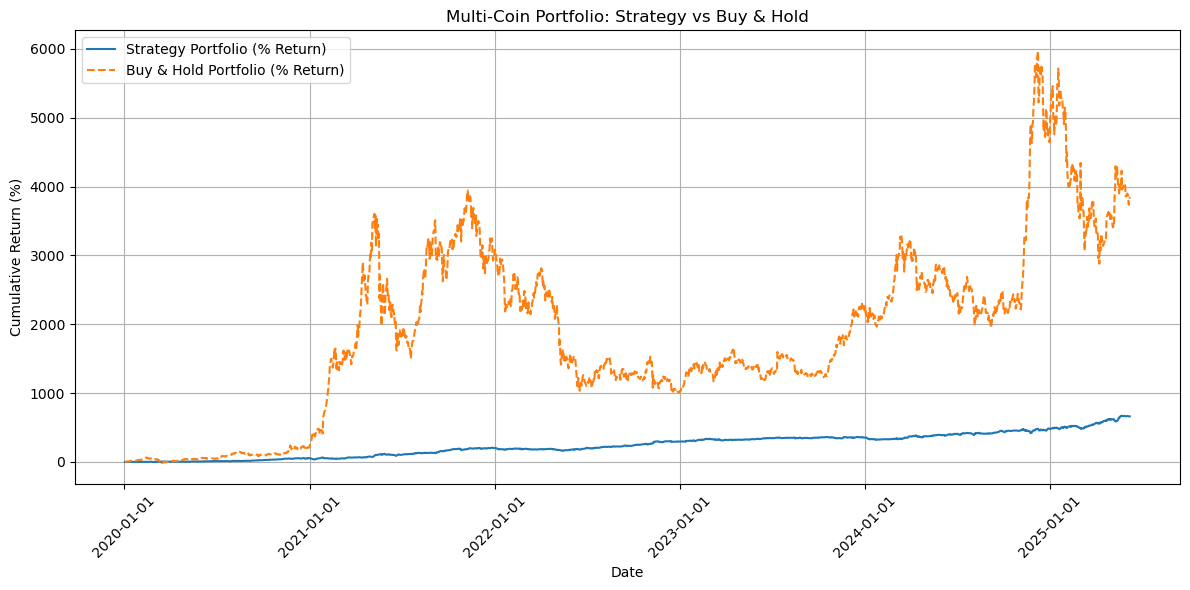


=== INDIVIDUAL COIN PERFORMANCE REPORT ===

=== Individual Coin Performance ===

          Total Return (%)  CAGR (%)  Max Drawdown (%)  Ann. Sharpe
Ticker                                                             
ETHUSDT             517.11     39.85            -46.09         1.05
BTCUSDT            1210.02     60.66            -20.76         1.74
BNBUSDT             175.01     20.49            -43.94         0.70
XRPUSDT             198.49     22.33            -65.09         0.67
DOGEUSDT           1252.60     61.61            -85.52         1.11
ADAUSDT             212.57     23.37            -60.17         0.69
XLMUSDT             213.46     23.43            -52.64         0.69
LINKUSDT            342.64     31.54            -66.48         0.80
AVAXUSDT            980.73     55.06            -45.56         1.10
TONUSDT              65.35      9.71            -24.47         0.72


In [5]:

# 6) Print portfolio summary
print("\n=== PORTFOLIO PERFORMANCE REPORT ===")
print(f"Period: {port_daily_pct.index[0]} to {port_daily_pct.index[-1]}  ({years:.2f} years)")
print(f"Total Return (Strategy):        {total_return_pct * 100:.2f}%")
print(f"CAGR (Strategy):                {cagr_pct * 100:.2f}%")
print(f"Max Drawdown (Strategy):        {max_drawdown_pct:.2f}%")
print(f"Annualized Sharpe (Strategy):   {annual_sharpe:.2f}")
print("--- BUY & HOLD FOR COMPARISON ---")
print(f"Total Return (Buy&Hold):        {bh_total_return_pct * 100:.2f}%")
print(f"CAGR (Buy&Hold):                {bh_cagr_pct * 100:.2f}%")
print(f"Annualized Sharpe (Buy&Hold):   {bh_annual_sharpe:.2f}")

# 7) (Optional) Plot Portfolio vs Buy & Hold
plt.figure(figsize=(12, 6))

cum_strat_pct = (1 + port_daily_pct).cumprod() - 1
plt.plot(
    cum_strat_pct.index,
    cum_strat_pct.values * 100,
    label="Strategy Portfolio (% Return)"
)

cum_bh_pct = (1 + bh_daily_pct).cumprod() - 1
plt.plot(
    cum_bh_pct.index,
    cum_bh_pct.values * 100,
    linestyle="--",
    label="Buy & Hold Portfolio (% Return)"
)

plt.title("Multi-Coin Portfolio: Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

    
print("\n=== INDIVIDUAL COIN PERFORMANCE REPORT ===")
summary = []

for ticker in paths.keys():
    pct = coin_daily_pct[ticker]
    # Cumulative return (%)
    total_return = (1 + pct).prod() - 1
    # Period length in years
    if len(pct) > 1:
        years_coin = (pd.to_datetime(pct.index[-1]) - pd.to_datetime(pct.index[0])).days / 365.25
    else:
        years_coin = np.nan
    # CAGR
    cagr_coin = ((1 + total_return) ** (1 / years_coin) - 1) if years_coin > 0 else np.nan
    # Sharpe (annualized)
    avg = pct.mean()
    vol = pct.std(ddof=1)
    sharpe = avg / vol if vol > 0 else np.nan
    annual_sharpe = sharpe * np.sqrt(365)
    # Max drawdown
    cum = (1 + pct).cumprod()
    peak = cum.cummax()
    dd = (cum - peak) / peak
    max_dd = dd.min() * 100

    summary.append({
        "Ticker": ticker,
        "Total Return (%)": total_return * 100,
        "CAGR (%)": cagr_coin * 100,
        "Max Drawdown (%)": max_dd,
        "Ann. Sharpe": annual_sharpe,
    })

# Make DataFrame
summary_df = pd.DataFrame(summary)
summary_df = summary_df.set_index("Ticker")
# Format display
print("\n=== Individual Coin Performance ===\n")
print(summary_df.round(2))

In [7]:
combined_trade_log.to_csv(r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\combined_trade_log_06.27.csv")

In [9]:
combined_trade_log.head(3)

,Ticker,Entry Time,Entry Price,Qty (coin),Side,Exit Price,Exit Time,PnL (USD),Return (%),exit_date
0,BTCUSDT,2020-01-03 16:00:00,7356.78000,2.718581e+01,Short,7386.03000,2020-01-03 16:45:00,-795.184850,-0.397592,2020-01-03
1,XLMUSDT,2020-01-03 16:00:00,0.04545,4.400440e+06,Short,0.04551,2020-01-03 16:45:00,-264.026403,-0.132013,2020-01-03
2,XRPUSDT,2020-01-03 16:15:00,0.19289,1.036860e+06,Short,0.19300,2020-01-03 17:00:00,-114.054643,-0.057027,2020-01-03


In [35]:
combined_trade_log.tail(3)

,Ticker,Entry Time,Entry Price,Qty (coin),Side,Exit Price,Exit Time,PnL (USD),Return (%),exit_date,PnL_pct,date,time_str,hour
107933,ADAUSDT,2025-06-07 03:00:00,0.6595,303260.045489,Short,0.662,2025-06-07 03:45:00,-758.150114,-0.379075,2025-06-07,-0.003791,2025-06-07,03:00,3
107934,TONUSDT,2025-06-07 05:00:00,3.1850,62794.348509,Short,3.183,2025-06-07 05:45:00,125.588697,0.062794,2025-06-07,0.000628,2025-06-07,05:00,5
107935,AVAXUSDT,2025-06-07 05:30:00,20.2700,9866.798224,Short,20.270,2025-06-07 06:15:00,0.000000,0.000000,2025-06-07,0.000000,2025-06-07,05:30,5


In [37]:
combined_trade_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107936 entries, 0 to 107935
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Ticker       107936 non-null  object        
 1   Entry Time   107936 non-null  datetime64[ns]
 2   Entry Price  107936 non-null  float64       
 3   Qty (coin)   107936 non-null  float64       
 4   Side         107936 non-null  object        
 5   Exit Price   107936 non-null  float64       
 6   Exit Time    107936 non-null  datetime64[ns]
 7   PnL (USD)    107936 non-null  float64       
 8   Return (%)   107936 non-null  float64       
 9   exit_date    107936 non-null  object        
 10  PnL_pct      107936 non-null  float64       
 11  date         107936 non-null  object        
 12  time_str     107936 non-null  object        
 13  hour         107936 non-null  int32         
dtypes: datetime64[ns](2), float64(6), int32(1), object(5)
memory usage: 11.1+ MB


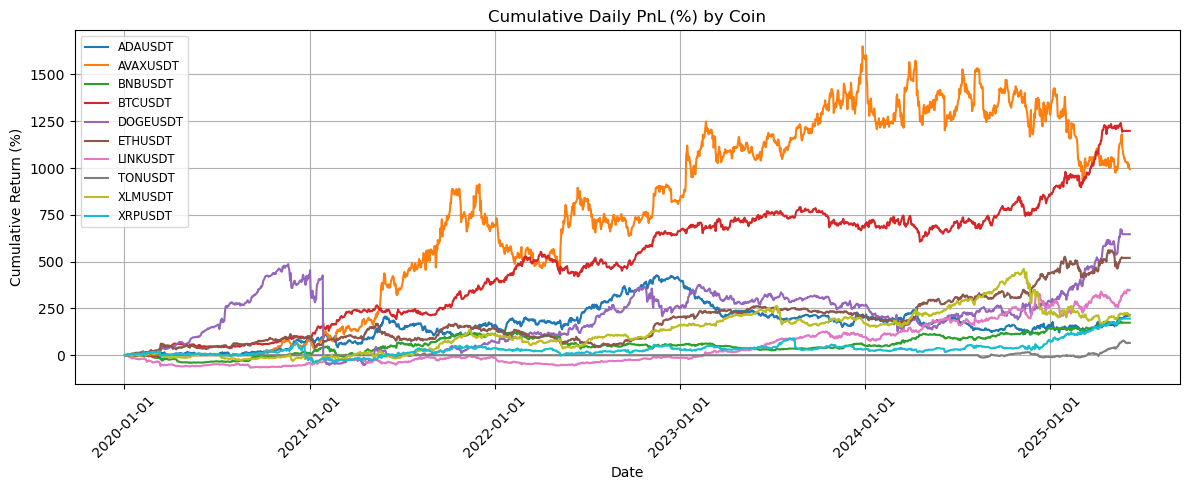

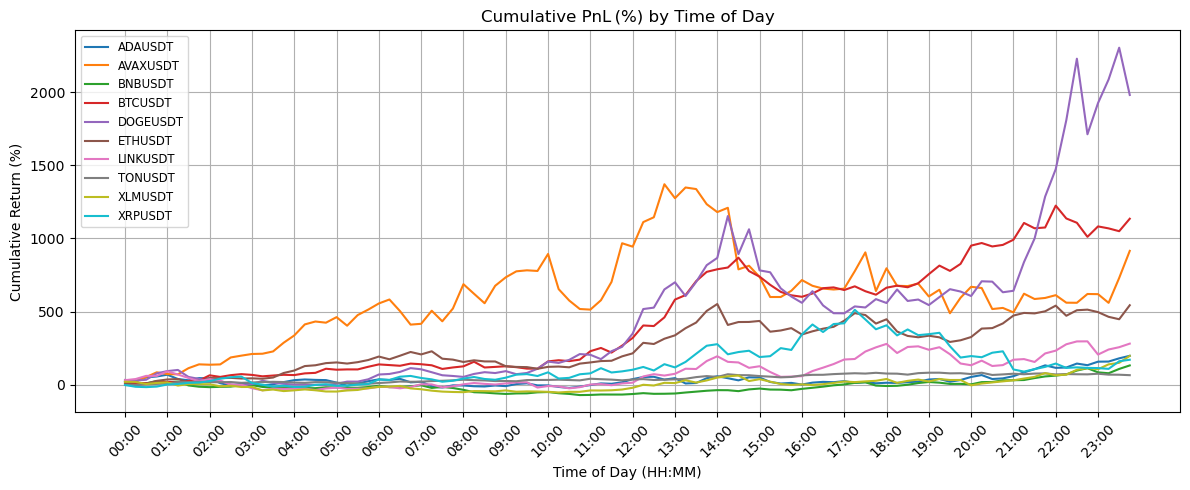

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ----------------------------------------------------------------------
# ASSUME `combined_trade_log` is your DataFrame with at least these columns:
#   • 'Ticker'      (e.g. 'BTCUSDT', 'XRPUSDT', etc.)
#   • 'Entry Time'  (datetime or string that can be parsed as datetime)
#   • 'PnL (USD)'   (float)
#
# If your DataFrame has a different name, replace `combined_trade_log` below
# with the correct variable.
# ----------------------------------------------------------------------

# 1) Convert 'Entry Time' to datetime (if it isn't already)
combined_trade_log['Entry Time'] = pd.to_datetime(combined_trade_log['Entry Time'])

# 2) Compute percent‐PnL assuming a fixed notional of 200,000 USD per trade
fixed_notional = 200_000.0
combined_trade_log['PnL_pct'] = combined_trade_log['PnL (USD)'] / fixed_notional

# 3) Extract calendar date and HH:MM string for grouping
combined_trade_log['date']     = combined_trade_log['Entry Time'].dt.date
combined_trade_log['time_str'] = combined_trade_log['Entry Time'].dt.strftime('%H:%M')

# 4) Build a sorted list of all tickers (should be 5 distinct coins)
tickers = sorted(combined_trade_log['Ticker'].unique().tolist())



# ================================
# PART A: DATE‐BASED CUMULATIVE PnL
# ================================

# A.1) Sum PnL_pct by ['Ticker', 'date']
df_daily = (
    combined_trade_log
    .groupby(['Ticker', 'date'])['PnL_pct']
    .sum()
    .reset_index()       # columns: ['Ticker', 'date', 'PnL_pct']
)

# A.2) Pivot so each column is one coin, index = date
df_pivot = df_daily.pivot(index='date', columns='Ticker', values='PnL_pct').fillna(0.0)

# A.3) Compute cumulative return (%) for each coin:
df_cum = (1 + df_pivot).cumprod() - 1

# A.4) Plot all five coins on a single date‐based figure
plt.figure(figsize=(12, 5))
for coin in tickers:
    plt.plot(
        df_cum.index,
        df_cum[coin] * 100,
        label=coin,
        linewidth=1.5
    )

plt.title('Cumulative Daily PnL (%) by Coin')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




# ===================================
# PART B: TIME‐OF‐DAY‐BASED CUMULATIVE PnL
# ===================================

# B.1) Sum PnL_pct by ['Ticker', 'time_str']
df_time = (
    combined_trade_log
    .groupby(['Ticker', 'time_str'])['PnL_pct']
    .sum()
    .reset_index()       # columns: ['Ticker', 'time_str', 'PnL_pct']
)

# B.2) Pivot so each column is one coin, index = time_str (e.g., '00:00', '00:15', …)
df_time_pivot = df_time.pivot(index='time_str', columns='Ticker', values='PnL_pct').fillna(0.0)

# B.3) Sort the index so '00:00', '00:15', …, '23:45'
df_time_pivot = df_time_pivot.sort_index()

# B.4) Compute cumulative return (%) for each coin by time‐of‐day
df_time_cum = (1 + df_time_pivot).cumprod() - 1

# B.5) Plot all five coins on a single time‐of‐day‐based figure
plt.figure(figsize=(12, 5))
for coin in tickers:
    plt.plot(
        df_time_cum.index,
        df_time_cum[coin] * 100,
        label=coin,
        linewidth=1.5
    )

plt.title('Cumulative PnL (%) by Time of Day')
plt.xlabel('Time of Day (HH:MM)')
plt.ylabel('Cumulative Return (%)')
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
# Reduce clutter by rotating every 4th label
xticks = df_time_cum.index[::4]
plt.xticks(xticks, rotation=45)
plt.tight_layout()
plt.show()


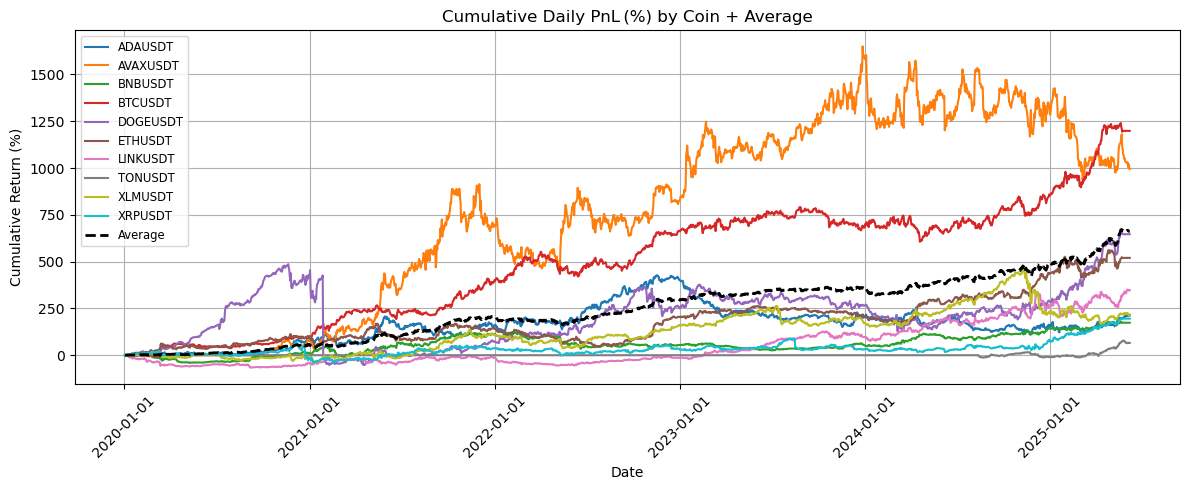

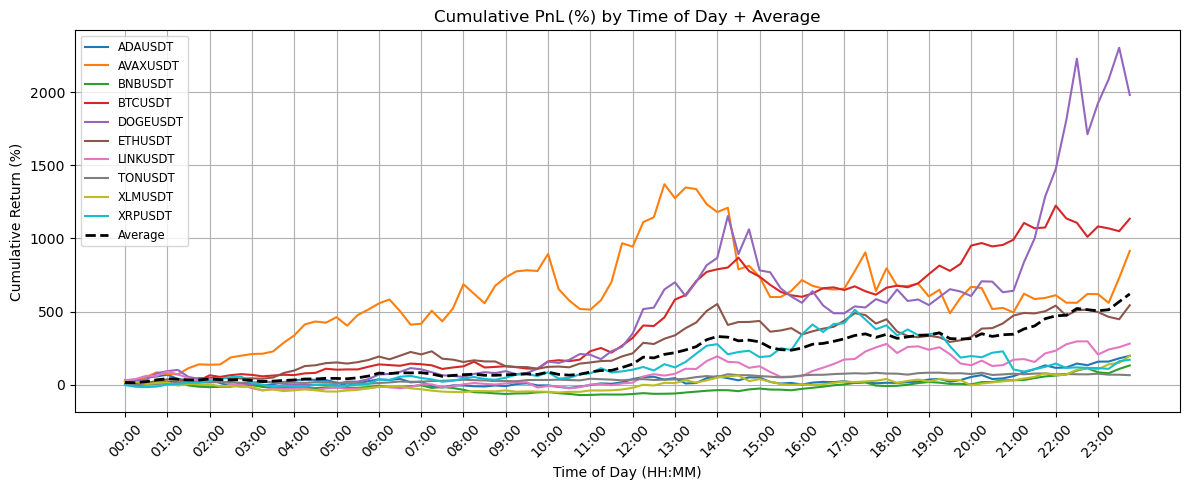

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ----------------------------------------------------------------------
# ASSUME `combined_trade_log` is your DataFrame with at least these columns:
#   • 'Ticker'      (e.g. 'BTCUSDT', 'XRPUSDT', etc.)
#   • 'Entry Time'  (datetime or string that can be parsed as datetime)
#   • 'PnL (USD)'   (float)
#
# If your DataFrame has a different name, replace `combined_trade_log` below
# with the correct variable.
# ----------------------------------------------------------------------

# 1) Convert 'Entry Time' to datetime (if it isn't already)
combined_trade_log['Entry Time'] = pd.to_datetime(combined_trade_log['Entry Time'])

# 2) Compute percent‐PnL assuming a fixed notional of 200,000 USD per trade
fixed_notional = 200_000.0
combined_trade_log['PnL_pct'] = combined_trade_log['PnL (USD)'] / fixed_notional

# 3) Extract calendar date and HH:MM string for grouping
combined_trade_log['date']     = combined_trade_log['Entry Time'].dt.date
combined_trade_log['time_str'] = combined_trade_log['Entry Time'].dt.strftime('%H:%M')

# 4) Build a sorted list of all tickers (should be 5 distinct coins)
tickers = sorted(combined_trade_log['Ticker'].unique().tolist())



# ================================
# PART A: DATE‐BASED CUMULATIVE PNL + AVERAGE
# ================================

# A.1) Sum PnL_pct by ['Ticker', 'date']
df_daily = (
    combined_trade_log
    .groupby(['Ticker', 'date'])['PnL_pct']
    .sum()
    .reset_index()       # columns: ['Ticker', 'date', 'PnL_pct']
)

# A.2) Pivot so each column is one coin, index = date
df_pivot = df_daily.pivot(index='date', columns='Ticker', values='PnL_pct').fillna(0.0)

# A.3) Compute average daily %‐PnL across all coins
df_pivot['Avg_Daily_pct'] = df_pivot[tickers].mean(axis=1)

# A.4) Compute cumulative return (%) for each coin
df_cum = (1 + df_pivot[tickers]).cumprod() - 1

# A.5) Compute cumulative return (%) for the average series
df_avg_cum = (1 + df_pivot['Avg_Daily_pct']).cumprod() - 1

# A.6) Plot all five coins + average on a single date‐based figure
plt.figure(figsize=(12, 5))
for coin in tickers:
    plt.plot(
        df_cum.index,
        df_cum[coin] * 100,
        label=coin,
        linewidth=1.5
    )

# Plot the average cumulative line (thicker and dashed)
plt.plot(
    df_avg_cum.index,
    df_avg_cum * 100,
    label='Average',
    linestyle='--',
    color='black',
    linewidth=2
)

plt.title('Cumulative Daily PnL (%) by Coin + Average')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




# ===================================
# PART B: TIME‐OF‐DAY‐BASED CUMULATIVE PNL + AVERAGE
# ===================================

# B.1) Sum PnL_pct by ['Ticker', 'time_str']
df_time = (
    combined_trade_log
    .groupby(['Ticker', 'time_str'])['PnL_pct']
    .sum()
    .reset_index()       # columns: ['Ticker', 'time_str', 'PnL_pct']
)

# B.2) Pivot so each column is one coin, index = time_str (e.g., '00:00', '00:15', …)
df_time_pivot = df_time.pivot(index='time_str', columns='Ticker', values='PnL_pct').fillna(0.0)

# B.3) Compute average PnL% at each time‐bucket
df_time_pivot['Avg_Time_pct'] = df_time_pivot[tickers].mean(axis=1)

# B.4) Sort the index so '00:00', '00:15', …, '23:45'
df_time_pivot = df_time_pivot.sort_index()

# B.5) Compute cumulative return (%) for each coin by time‐of‐day
df_time_cum = (1 + df_time_pivot[tickers]).cumprod() - 1

# B.6) Compute cumulative return (%) for the average time series
df_avg_time_cum = (1 + df_time_pivot['Avg_Time_pct']).cumprod() - 1

# B.7) Plot all five coins + average on a single time‐of‐day‐based figure
plt.figure(figsize=(12, 5))
for coin in tickers:
    plt.plot(
        df_time_cum.index,
        df_time_cum[coin] * 100,
        label=coin,
        linewidth=1.5
    )

# Plot the average cumulative line (thicker and dashed)
plt.plot(
    df_avg_time_cum.index,
    df_avg_time_cum * 100,
    label='Average',
    linestyle='--',
    color='black',
    linewidth=2
)

plt.title('Cumulative PnL (%) by Time of Day + Average')
plt.xlabel('Time of Day (HH:MM)')
plt.ylabel('Cumulative Return (%)')
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
# Reduce clutter by rotating every 4th label
xticks = df_time_cum.index[::4]
plt.xticks(xticks, rotation=45)
plt.tight_layout()
plt.show()


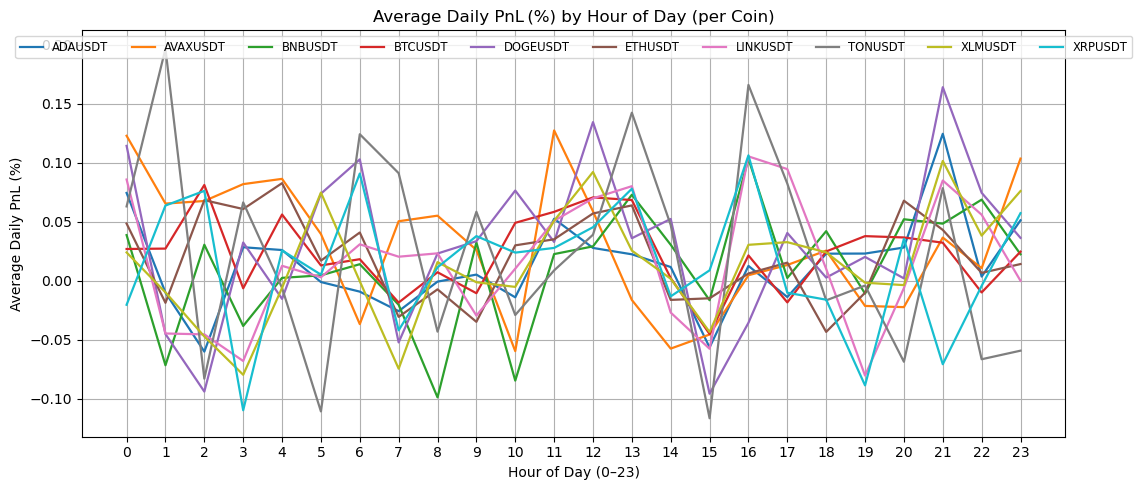

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# ASSUME `combined_trade_log` is your DataFrame with at least these columns:
#   • 'Ticker'      (e.g. 'BTCUSDT', 'XRPUSDT', etc.)
#   • 'Entry Time'  (datetime or string that can be parsed as datetime)
#   • 'PnL (USD)'   (float)
#
# If your DataFrame has a different name, replace `combined_trade_log` below
# with the correct variable.
# ----------------------------------------------------------------------

# 1) Parse 'Entry Time' as datetime (if it isn’t already)
combined_trade_log['Entry Time'] = pd.to_datetime(combined_trade_log['Entry Time'])

# 2) Compute percent‐PnL assuming a fixed notional of $200,000 per trade
fixed_notional = 200_000.0
combined_trade_log['PnL_pct'] = combined_trade_log['PnL (USD)'] / fixed_notional

# 3) Extract calendar date and hour‐of‐day for grouping
combined_trade_log['date'] = combined_trade_log['Entry Time'].dt.date
combined_trade_log['hour'] = combined_trade_log['Entry Time'].dt.hour

# 4) Aggregate "daily PnL_pct per coin per hour"
#    This sums up all trades for each (Ticker, date, hour)
df_hourly_daily = (
    combined_trade_log
    .groupby(['Ticker', 'date', 'hour'])['PnL_pct']
    .sum()
    .reset_index()   # columns now: ['Ticker', 'date', 'hour', 'PnL_pct']
)

# 5) Compute "average daily PnL_pct at each hour" by averaging across dates
#    For each coin and each hour, take the mean of that day's PnL_pct
df_hourly_avg = (
    df_hourly_daily
    .groupby(['Ticker', 'hour'])['PnL_pct']
    .mean()
    .reset_index()   # columns: ['Ticker', 'hour', 'PnL_pct']
)

# 6) Pivot into a table: index = hour (0–23), columns = Ticker, values = average PnL_pct
df_hourly_pivot = df_hourly_avg.pivot(index='hour', columns='Ticker', values='PnL_pct').fillna(0.0)

# 7) (Optional) Convert to percentage for readability
df_hourly_pct = df_hourly_pivot * 100.0
# Now `df_hourly_pct.loc[h, coin]` is the average daily PnL (%) that coin achieved during hour = h.

# -------------------------------
# 8) Plotting “Average Daily PnL (%) by Hour of Day” for each coin
# -------------------------------
plt.figure(figsize=(12, 5))
for coin in df_hourly_pct.columns:
    plt.plot(
        df_hourly_pct.index,
        df_hourly_pct[coin],
        label=coin,
        linewidth=1.6
    )

plt.title('Average Daily PnL (%) by Hour of Day (per Coin)')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Average Daily PnL (%)')
plt.xticks(range(0, 24))       # show all 24 hours on x‐axis
plt.grid(True)
plt.legend(loc='upper center', fontsize='small', ncol=len(df_hourly_pct.columns))
plt.tight_layout()
plt.show()


In [15]:
import pandas as pd

# Step 1: Parse datetime
combined_trade_log['Entry Time'] = pd.to_datetime(combined_trade_log['Entry Time'])

# Step 2: Compute percentage PnL (assuming fixed notional of $200,000 per trade)
fixed_notional = 200_000.0
combined_trade_log['PnL_pct'] = combined_trade_log['PnL (USD)'] / fixed_notional

# Step 3: Extract hour of day
combined_trade_log['hour'] = combined_trade_log['Entry Time'].dt.hour

# Step 4: Compute average PnL per trade (%) for each coin by hour
df_hourly_pct_trade = (
    combined_trade_log
    .groupby(['hour', 'Ticker'])['PnL_pct']
    .mean()
    .unstack(fill_value=0.0) * 100.0  # convert to percentage
)

# Result: df_hourly_pct_trade is a table:
# Rows = hours (0–23), Columns = coins (tickers), Values = average PnL per trade (%)


In [16]:
df_hourly_pct_trade.head(3)

Ticker,ADAUSDT,AVAXUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,ETHUSDT,LINKUSDT,TONUSDT,XLMUSDT,XRPUSDT
hour,,,,,,,,,,
0,0.073241,0.120756,0.038124,0.026654,0.113623,0.047952,0.085307,0.063058,0.023714,-0.019865
1,-0.009917,0.064466,-0.071178,0.026993,-0.044452,-0.018482,-0.044044,0.196710,-0.009710,0.063116
2,-0.059776,0.067466,0.030494,0.080256,-0.093436,0.067833,-0.044980,-0.082976,-0.046879,0.075543


In [23]:
pip install gymnasium stable-baselines3 numpy pandas matplotlib

   ---------------------------------------- 0.0/965.4 kB ? eta -:--:--
   --------------------------------------- 965.4/965.4 kB 15.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [21]:
df_hourly_pct_trade.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 0 to 23
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ADAUSDT   24 non-null     float64
 1   AVAXUSDT  24 non-null     float64
 2   BNBUSDT   24 non-null     float64
 3   BTCUSDT   24 non-null     float64
 4   DOGEUSDT  24 non-null     float64
 5   ETHUSDT   24 non-null     float64
 6   LINKUSDT  24 non-null     float64
 7   TONUSDT   24 non-null     float64
 8   XLMUSDT   24 non-null     float64
 9   XRPUSDT   24 non-null     float64
dtypes: float64(10)
memory usage: 2.0 KB


In [41]:
combined_trade_log.info

<bound method DataFrame.info of           Ticker          Entry Time  Entry Price    Qty (coin)   Side  \
0        BTCUSDT 2020-01-03 16:00:00   7356.78000  2.718581e+01  Short   
1        XLMUSDT 2020-01-03 16:00:00      0.04545  4.400440e+06  Short   
2        XRPUSDT 2020-01-03 16:15:00      0.19289  1.036860e+06  Short   
3        BNBUSDT 2020-01-03 17:30:00     13.68990  1.460931e+04   Long   
4        BNBUSDT 2020-01-03 19:00:00     13.57120  1.473709e+04   Long   
...          ...                 ...          ...           ...    ...   
107931   XLMUSDT 2025-06-07 03:00:00      0.26410  7.572889e+05  Short   
107932  LINKUSDT 2025-06-07 03:00:00     13.77000  1.452433e+04  Short   
107933   ADAUSDT 2025-06-07 03:00:00      0.65950  3.032600e+05  Short   
107934   TONUSDT 2025-06-07 05:00:00      3.18500  6.279435e+04  Short   
107935  AVAXUSDT 2025-06-07 05:30:00     20.27000  9.866798e+03  Short   

        Exit Price           Exit Time    PnL (USD)  Return (%)   exit_date  \


In [53]:
combined_trade_log.head(3)

0   -0.397592
1   -0.132013
2   -0.057027
Name: Return (%), dtype: float64

In [61]:
# import gymnasium as gym
# from gymnasium import spaces
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from stable_baselines3 import PPO
# from stable_baselines3.common.vec_env import DummyVecEnv

# class CryptoPortfolioEnv(gym.Env):
#     def __init__(self, returns_df, lookback=12, transaction_cost=0.001):  # half day lookback for hourly data
#         super().__init__()
#         self.returns = returns_df.dropna()
#         self.lookback = lookback
#         self.transaction_cost = transaction_cost
#         self.assets = self.returns.shape[1]

#         if len(self.returns) < self.lookback + 1:
#             raise ValueError("Not enough data for the given lookback period.")

#         self.data = self.returns.values
#         self.current_step = 0

#         self.action_space = spaces.Box(low=0, high=1, shape=(self.assets,), dtype=np.float32)
#         self.observation_space = spaces.Box(low=-np.inf, high=np.inf, 
#                                           shape=(self.lookback, self.assets), dtype=np.float32)

#         self.weights = np.array([1.0 / self.assets] * self.assets)
#         self.prev_weights = self.weights.copy()
#         self.portfolio_value = 1.0
#         self.return_history = []
#         self.value_history = [self.portfolio_value]

#     def reset(self, *, seed=None, options=None):
#         super().reset(seed=seed)
#         self.current_step = 0
#         self.weights = np.array([1.0 / self.assets] * self.assets)
#         self.prev_weights = self.weights.copy()
#         self.portfolio_value = 1.0
#         self.return_history = []
#         self.value_history = [self.portfolio_value]

#         obs = self._get_observation()
#         return obs, {}

#     def _get_observation(self):
#         return self.data[self.current_step:self.current_step + self.lookback]

#     def step(self, action):
#         # 1. Normalize action to sum to 1 (portfolio weights)
#         action = np.clip(action, 0, 1)
#         action_sum = np.sum(action)
#         if action_sum > 0:
#             action = action / action_sum
#         else:
#             action = np.array([1.0 / self.assets] * self.assets)

#         # 2. Get current hourly returns
#         r = self.data[self.current_step + self.lookback]

#         # 3. Calculate transaction costs
#         turnover = np.sum(np.abs(action - self.prev_weights))
#         transaction_cost = self.transaction_cost * turnover

#         # 4. Compute portfolio return (with safety clipping for crypto volatility)
#         portfolio_return = np.dot(action, r) - transaction_cost
#         portfolio_return = np.clip(portfolio_return, -0.5, 0.5)  # aggressive clipping for crypto

#         # 5. Update portfolio value
#         self.portfolio_value *= (1 + portfolio_return)
#         self.portfolio_value = max(self.portfolio_value, 1e-4)  # prevent complete collapse

#         # 6. Update state
#         self.return_history.append(portfolio_return)
#         self.value_history.append(self.portfolio_value)
#         self.prev_weights = action
#         self.weights = action
#         self.current_step += 1

#         # 7. Calculate reward (using Sharpe ratio with recent 24h window)
#         if len(self.return_history) >= 24:  # 24 hours
#             returns = np.array(self.return_history[-24:])
#             sharpe = np.mean(returns) / (np.std(returns) + 1e-8)
#             reward = sharpe
#         else:
#             reward = portfolio_return  # fallback to raw return if not enough history

#         # 8. Done condition
#         done = self.current_step + self.lookback >= len(self.data) or self.portfolio_value < 0.01

#         # 9. Prepare observation and info
#         obs = self._get_observation()
#         info = {
#             "portfolio_value": self.portfolio_value,
#             "weights": self.weights.copy(),
#             "transaction_cost": transaction_cost,
#             "step": self.current_step,
#         }

#         return obs, reward, done, False, info

# # Assuming df_hourly_pct_trade is your DataFrame with hourly returns
# # Convert the index to datetime if it's not already
# #combined_trade_log.index = pd.to_datetime(df_hourly_pct_trade.index)
# train_df = combined_trade_log[:'2023-12-31']
# test_df  = combined_trade_log['2024-01-01':]
# # Create environment
# env = DummyVecEnv([lambda: CryptoPortfolioEnv(train_df, lookback=12)])  # half day lookback (12 hours)
# # Train PPO agent
# model = PPO(
#     "MlpPolicy", 
#     env, 
#     verbose=1, 
#     learning_rate=3e-4,
#     ent_coef=0.01,  # Higher exploration for crypto
#     gamma=0.99,
#     gae_lambda=0.95,
#     clip_range=0.2,
#     n_steps=256,
#     batch_size=64
# )

# # Train for more timesteps due to crypto volatility
# model.learn(total_timesteps=50000)

# # Evaluation
# def evaluate_model(model, env, df):
#     obs = env.reset()
#     done = False
#     portfolio_values = []
#     weight_history = []
    
#     while not done:
#         action, _ = model.predict(obs, deterministic=True)
#         obs, reward, done, info = env.step(action)
#         portfolio_values.append(info[0]['portfolio_value'])
#         weight_history.append(info[0]['weights'])
    
#     # Plot results
#     plt.figure(figsize=(15, 8))
    
#     # Portfolio value
#     plt.subplot(2, 1, 1)
#     plt.plot(portfolio_values)
#     plt.title('Portfolio Value Over Time')
#     plt.ylabel('Value')
#     plt.grid(True)
    
#     # Asset weights
#     plt.subplot(2, 1, 2)
#     weight_history = np.array(weight_history)
#     for i, ticker in enumerate(df.columns):
#         plt.plot(weight_history[:, i], label=ticker)
#     plt.title('Asset Allocation Over Time')
#     plt.xlabel('Time Step')
#     plt.ylabel('Weight')
#     plt.legend()
#     plt.grid(True)
    
#     plt.tight_layout()
#     plt.savefig('Portfolio_Value_Over_Time_Training.png', dpi=300, bbox_inches='tight')
      # plt.savefig('Asset_Allocation_Over_Time_Training.png', dpi=300, bbox_inches='tight')
#     plt.show()
    
#     return portfolio_values, weight_history

# # Run evaluation
# portfolio_values, weights = evaluate_model(model, env, df_hourly_pct_trade)

# # Strategy wrapper for live trading
# class CryptoRLStrategy:
#     def __init__(self, model, lookback=168):
#         self.model = model
#         self.lookback = lookback
        
#     def get_weights(self, returns_df):
#         if len(returns_df) < self.lookback:
#             raise ValueError(f"Need at least {self.lookback} periods of data")
            
#         obs = returns_df[-self.lookback:].values
#         obs = obs.reshape(1, self.lookback, -1)
        
#         action, _ = self.model.predict(obs, deterministic=True)
#         weights = np.clip(action[0], 0, 1)
#         return weights / np.sum(weights)

In [7]:
pip install stable-baselines3[extra]

   ---------------------------------------- 0.0/3.5 MB ? eta -:--:--
   ---------------------------------------- 3.5/3.5 MB 67.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/965.4 kB ? eta -:--:--
   --------------------------------------- 965.4/965.4 kB 46.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---- ---------------------------------- 25.4/216.1 MB 124.0 MB/s eta 0:00:02
   ------- ------------------------------- 43.8/216.1 MB 103.1 MB/s eta 0:00:02
   ------------ -------------------------- 66.8/216.1 MB 103.9 MB/s eta 0:00:02
   ---------------- ---------------------- 89.1/216.1 MB 105.3 MB/s eta 0:00:02
   ------------------- ------------------ 110.4/216.1 MB 105.2 MB/s eta 0:00:02
   ----------------------- -------------- 136.1/216.1 MB 107.3 MB/s eta 0:00:01
   ---------------------------- --------- 161.0/216.1 MB 108.3 MB/s eta 0:00:01
   ------------------------------- ------ 179.8/216.1 MB 106.4 MB/s eta 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\USER\anaconda3\python.exe -m pip install --upgrade pip


In [63]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from stable_baselines3 import PPO
# from stable_baselines3.common.vec_env import DummyVecEnv

# class CryptoRLBacktester:
#     def __init__(self, returns_df, model=None, lookback=12, transaction_cost=0.001, initial_cash=100_000):
#         """
#         Initialize backtester with:
#         - returns_df: DataFrame of hourly percentage returns (your df_hourly_pct_trade)
#         - model: Pre-trained RL model (optional)
#         - lookback: Number of hours to use for observation (default 1 week)
#         - transaction_cost: Cost per trade
#         - initial_cash: Starting capital
#         """
#         self.returns = returns_df.dropna()
#         self.lookback = lookback
#         self.transaction_cost = transaction_cost
#         self.initial_cash = initial_cash
#         self.tickers = returns_df.columns.tolist()
        
#         # Create environment for model
#         self.env= DummyVecEnv([lambda: CryptoPortfolioEnv(returns_df, lookback=lookback)])
        
#         # Initialize or load model
#         if model is None:
#             self.model = PPO(
#                 "MlpPolicy", 
#                 self.env, 
#                 verbose=1, 
#                 learning_rate=3e-4,
#                 ent_coef=0.01,
#                 gamma=0.99,
#                 gae_lambda=0.95,
#                 clip_range=0.2,
#                 n_steps=256,
#                 batch_size=64
#             )
#         else:
#             self.model = model
            
#     def train_model(self, timesteps=50000):
#         """Train the RL model"""
#         self.model.learn(total_timesteps=timesteps)
#         return self.model
    
#     def run_backtest(self):
#         """Run backtest using trained model"""
#         # Initialize tracking
#         self.portfolio_values = [self.initial_cash]
#         self.weights_history = pd.DataFrame(index=self.returns.index, columns=self.tickers)
#         self.transaction_costs = []
        
#         # Start from first valid point
#         start_idx = self.lookback
#         current_weights = np.array([1.0/len(self.tickers)] * len(self.tickers))
#         cash = self.initial_cash
        
#         for i in range(start_idx, len(self.returns)):
#             # Get observation window
#             obs = self.returns.iloc[i-self.lookback:i].values
#             obs = obs.reshape(1, self.lookback, -1)
            
#             # Get action from model
#             action, _ = self.model.predict(obs, deterministic=True)
            
#             # Normalize weights
#             new_weights = np.clip(action[0], 0, 1)
#             new_weights = new_weights / np.sum(new_weights)
            
#             # Calculate transaction cost
#             turnover = np.sum(np.abs(new_weights - current_weights))
#             cost = self.transaction_cost * turnover * cash
#             cash -= cost
#             self.transaction_costs.append(cost)
            
#             # Apply returns
#             current_returns = self.returns.iloc[i].values
#             portfolio_return = np.dot(new_weights, current_returns)
#             cash *= (1 + portfolio_return)
            
#             # Update tracking
#             self.portfolio_values.append(cash)
#             self.weights_history.iloc[i] = new_weights
#             current_weights = new_weights
            
#         # Create results DataFrame
#         portfolio_index = [self.returns.index[start_idx-1]] + list(self.returns.index[start_idx:])
#         portfolio_values_series = pd.Series(self.portfolio_values, index=portfolio_index)
#         self.results = pd.DataFrame({
#         'Portfolio Value': portfolio_values_series,
#         'Returns': portfolio_values_series.pct_change().fillna(0)})
#         return self.results
    
#     def plot_results(self):
#         """Plot backtest results"""
#         fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
        
#         # Portfolio value
#         ax1.plot(self.results['Portfolio Value'])
#         ax1.set_title('Portfolio Value Over Time')
#         ax1.set_ylabel('Value')
#         ax1.grid(True)
        
#         # Asset weights
#         for ticker in self.tickers:
#             ax2.plot(self.weights_history[ticker], label=ticker)
#         ax2.set_title('Asset Allocation Over Time')
#         ax2.set_xlabel('Date')
#         ax2.set_ylabel('Weight')
#         ax2.legend()
#         ax2.grid(True)
        
#         plt.tight_layout()
#         plt.savefig('Portfolio_Value_Over_Time.png', dpi=300, bbox_inches='tight')
#         plt.savefig('Asset_Allocation_Over_Time.png', dpi=300, bbox_inches='tight')
#         plt.show()
    
#     def get_metrics(self):
#         """Calculate performance metrics"""
#         r = self.results['Returns']
#         value = self.results['Portfolio Value']
#         max_dd = (value / value.cummax() - 1).min()
        
#         # Calculate hourly metrics, can annualize later if needed
#         return {
#             'Total Return': value.iloc[-1] / value.iloc[0] - 1,
#             'Mean Return': r.mean(),
#             'Volatility': r.std(),
#             'Sharpe Ratio': r.mean() / r.std(),
#             'Max Drawdown': max_dd,
#             'Avg Turnover': np.mean(np.abs(self.weights_history.diff().dropna()).sum(axis=1)),
#             'Total Transaction Costs': sum(self.transaction_costs)
#         }

# # Example usage with your data:
# # Assuming df_hourly_pct_trade is your DataFrame of hourly returns

# # Initialize backtester
# #backtester = CryptoRLBacktester(df_hourly_pct_trade)
# backtester = CryptoRLBacktester(test_df, model=model, lookback=12)
# results    = backtester.run_backtest()

# # Train model (optional - can load pre-trained)
# backtester.train_model(timesteps=50000)

# # Run backtest
# results = backtester.run_backtest()

# # Plot results
# backtester.plot_results()

# # Get performance metrics
# metrics = backtester.get_metrics()
# print("\n=== Performance Metrics ===")
# for k, v in metrics.items():
#     print(f"{k}: {v:.4f}")

In [67]:
# import pandas as pd

# # Step 1: Load your CSV file
# file_path = r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\combined_trade_log 06.27.csv"
# df = pd.read_csv(file_path)

# # Step 2: Convert Entry Time to datetime with dayfirst
# df['Entry Time'] = pd.to_datetime(df['Entry Time'], dayfirst=True)

# # Step 3: Calculate PnL as percent of notional (change if you have a different notional)
# fixed_notional = 200_000.0
# df['PnL_pct'] = df['PnL (USD)'] / fixed_notional

# # Step 4: Floor Entry Time to hour and get ticker
# df['dt_hour'] = df['Entry Time'].dt.floor('H')

# # Step 5: Pivot into hourly returns timeseries DataFrame
# df_hourly_pct_trade = (
#     df.groupby(['dt_hour', 'Ticker'])['PnL_pct']
#     .sum()
#     .unstack(fill_value=0.0)
#     .sort_index()
# )

# # Step 6: Show the first 3 rows
# print(df_hourly_pct_trade.head(3))


Ticker               ADAUSDT  AVAXUSDT   BNBUSDT   BTCUSDT  DOGEUSDT  ETHUSDT  \
dt_hour                                                                         
2020-01-03 16:00:00      0.0       0.0  0.000000 -0.003976  0.000000      0.0   
2020-01-03 17:00:00      0.0       0.0 -0.003243  0.000000  0.000000      0.0   
2020-01-03 19:00:00      0.0       0.0  0.005497  0.004905  0.001037      0.0   

Ticker               LINKUSDT  TONUSDT   XLMUSDT  XRPUSDT  
dt_hour                                                    
2020-01-03 16:00:00       0.0      0.0 -0.001320 -0.00057  
2020-01-03 17:00:00       0.0      0.0  0.000000  0.00000  
2020-01-03 19:00:00       0.0      0.0  0.005524  0.00000  


C:\Users\USER\AppData\Local\Temp\ipykernel_66148\3174446973.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['dt_hour'] = df['Entry Time'].dt.floor('H')


In [23]:
pip install gym

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\USER\anaconda3\python.exe -m pip install --upgrade pip


In [25]:
pip install "shimmy>=2.0"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\USER\anaconda3\python.exe -m pip install --upgrade pip


C:\Users\USER\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


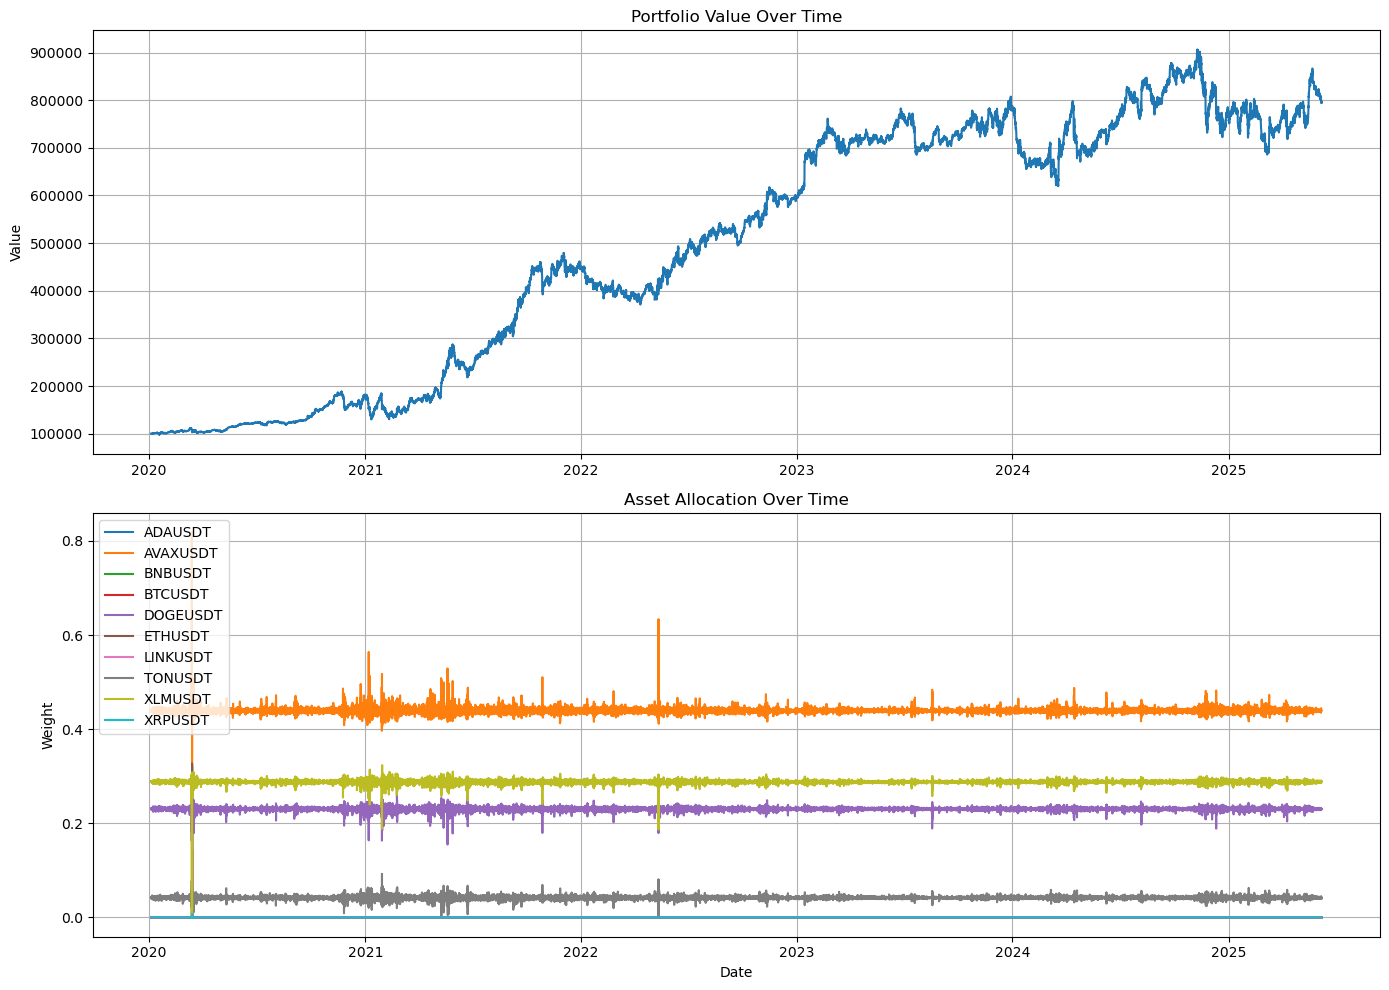


=== Performance Metrics ===
Total Return: 6.9388
Mean Return: 0.0001
Volatility: 0.0040
Sharpe Ratio: 0.0164
Max Drawdown: -0.3126
Avg Turnover: 0.0118
Total Transaction Costs: 183010.7565


In [69]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import gym
# from gym import spaces
# from stable_baselines3 import PPO
# from stable_baselines3.common.vec_env import DummyVecEnv

# # === DATA CLEANING ===
# # Remove all rows where ALL tickers are 0 or NaN (no trades that hour)
# df_hourly_pct_trade = df_hourly_pct_trade[(df_hourly_pct_trade != 0).any(axis=1)]
# df_hourly_pct_trade = df_hourly_pct_trade.dropna(how='all')

# # --- ENVIRONMENT CLASS ---
# class CryptoPortfolioEnv(gym.Env):
#     def __init__(self, returns_df, lookback=12):
#         super().__init__()
#         self.returns_df = returns_df
#         self.lookback = lookback
#         self.n_assets = returns_df.shape[1]
#         self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
#         self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(lookback, self.n_assets), dtype=np.float32)
#         self.reset()

#     def reset(self):
#         self.current_step = self.lookback
#         self.done = False
#         self.current_weights = np.ones(self.n_assets) / self.n_assets
#         return self._get_obs()

#     def _get_obs(self):
#         return self.returns_df.iloc[self.current_step - self.lookback:self.current_step].values

#     def step(self, action):
#         # Defensive: Normalize weights safely (avoid NaNs)
#         weights = np.clip(action, 0, 1)
#         if np.sum(weights) == 0:
#             weights = np.ones_like(weights) / len(weights)
#         else:
#             weights = weights / np.sum(weights)
#         returns = self.returns_df.iloc[self.current_step].values
#         reward = np.dot(weights, returns)
#         self.current_step += 1
#         self.done = self.current_step >= len(self.returns_df)
#         obs = self._get_obs() if not self.done else np.zeros((self.lookback, self.n_assets))
#         info = {'weights': weights}
#         return obs, reward, self.done, info

# # --- RL BACKTESTER CLASS ---
# class CryptoRLBacktester:
#     def __init__(self, returns_df, model=None, lookback=12, transaction_cost=0.001, initial_cash=100_000):
#         self.returns = returns_df.dropna()
#         self.lookback = lookback
#         self.transaction_cost = transaction_cost
#         self.initial_cash = initial_cash
#         self.tickers = returns_df.columns.tolist()
#         self.env = DummyVecEnv([lambda: CryptoPortfolioEnv(self.returns, lookback=lookback)])
#         if model is None:
#             self.model = PPO(
#                 "MlpPolicy", self.env, verbose=0,
#                 learning_rate=3e-4, ent_coef=0.01,
#                 gamma=0.99, gae_lambda=0.95,
#                 clip_range=0.2, n_steps=256, batch_size=64)
#         else:
#             self.model = model

#     def train_model(self, timesteps=10000):
#         self.model.learn(total_timesteps=timesteps)
#         return self.model

#     def run_backtest(self):
#         self.portfolio_values = [self.initial_cash]
#         self.weights_history = pd.DataFrame(np.nan, index=self.returns.index, columns=self.tickers)
#         self.transaction_costs = []
#         start_idx = self.lookback
#         current_weights = np.ones(len(self.tickers)) / len(self.tickers)
#         cash = self.initial_cash
#         for i in range(start_idx, len(self.returns)):
#             obs = self.returns.iloc[i-self.lookback:i].values
#             obs = obs.reshape(1, self.lookback, -1)
#             action, _ = self.model.predict(obs, deterministic=True)
#             # Defensive: Normalize weights safely
#             new_weights = np.clip(action[0], 0, 1)
#             if np.sum(new_weights) == 0:
#                 new_weights = np.ones_like(new_weights) / len(new_weights)
#             else:
#                 new_weights = new_weights / np.sum(new_weights)
#             turnover = np.sum(np.abs(new_weights - current_weights))
#             cost = self.transaction_cost * turnover * cash
#             cash -= cost
#             self.transaction_costs.append(cost)
#             portfolio_return = np.dot(new_weights, self.returns.iloc[i].values)
#             cash *= (1 + portfolio_return)
#             self.portfolio_values.append(cash)
#             self.weights_history.iloc[i] = new_weights
#             current_weights = new_weights

#         # Prepare a pandas Series for portfolio values to enable pct_change()
#         portfolio_index = [self.returns.index[start_idx-1]] + list(self.returns.index[start_idx:])
#         portfolio_values_series = pd.Series(self.portfolio_values, index=portfolio_index)
#         self.results = pd.DataFrame({
#             'Portfolio Value': portfolio_values_series,
#             'Returns': portfolio_values_series.pct_change().fillna(0)
#         })
#         return self.results

#     def plot_results(self):
#         fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
#         ax1.plot(self.results['Portfolio Value'])
#         ax1.set_title('Portfolio Value Over Time')
#         ax1.set_ylabel('Value')
#         ax1.grid(True)
#         for ticker in self.tickers:
#             ax2.plot(self.weights_history[ticker], label=ticker)
#         ax2.set_title('Asset Allocation Over Time')
#         ax2.set_xlabel('Date')
#         ax2.set_ylabel('Weight')
#         ax2.legend()
#         ax2.grid(True)
#         plt.tight_layout()
#         plt.show()

#     def get_metrics(self):
#         r = self.results['Returns']
#         value = self.results['Portfolio Value']
#         max_dd = (value / value.cummax() - 1).min()
#         return {
#             'Total Return': value.iloc[-1] / value.iloc[0] - 1,
#             'Mean Return': r.mean(),
#             'Volatility': r.std(),
#             'Sharpe Ratio': r.mean() / (r.std() + 1e-10),
#             'Max Drawdown': max_dd,
#             'Avg Turnover': np.mean(np.abs(self.weights_history.diff().dropna()).sum(axis=1)),
#             'Total Transaction Costs': sum(self.transaction_costs)
#         }

# # --- RUN RL TRAINING AND BACKTEST ---
# backtester = CryptoRLBacktester(df_hourly_pct_trade)
# backtester.train_model(timesteps=10000)  # Increase timesteps for better results!
# results = backtester.run_backtest()
# backtester.plot_results()
# metrics = backtester.get_metrics()
# print("\n=== Performance Metrics ===")
# for k, v in metrics.items():
#     print(f"{k}: {v:.4f}")


C:\Users\USER\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


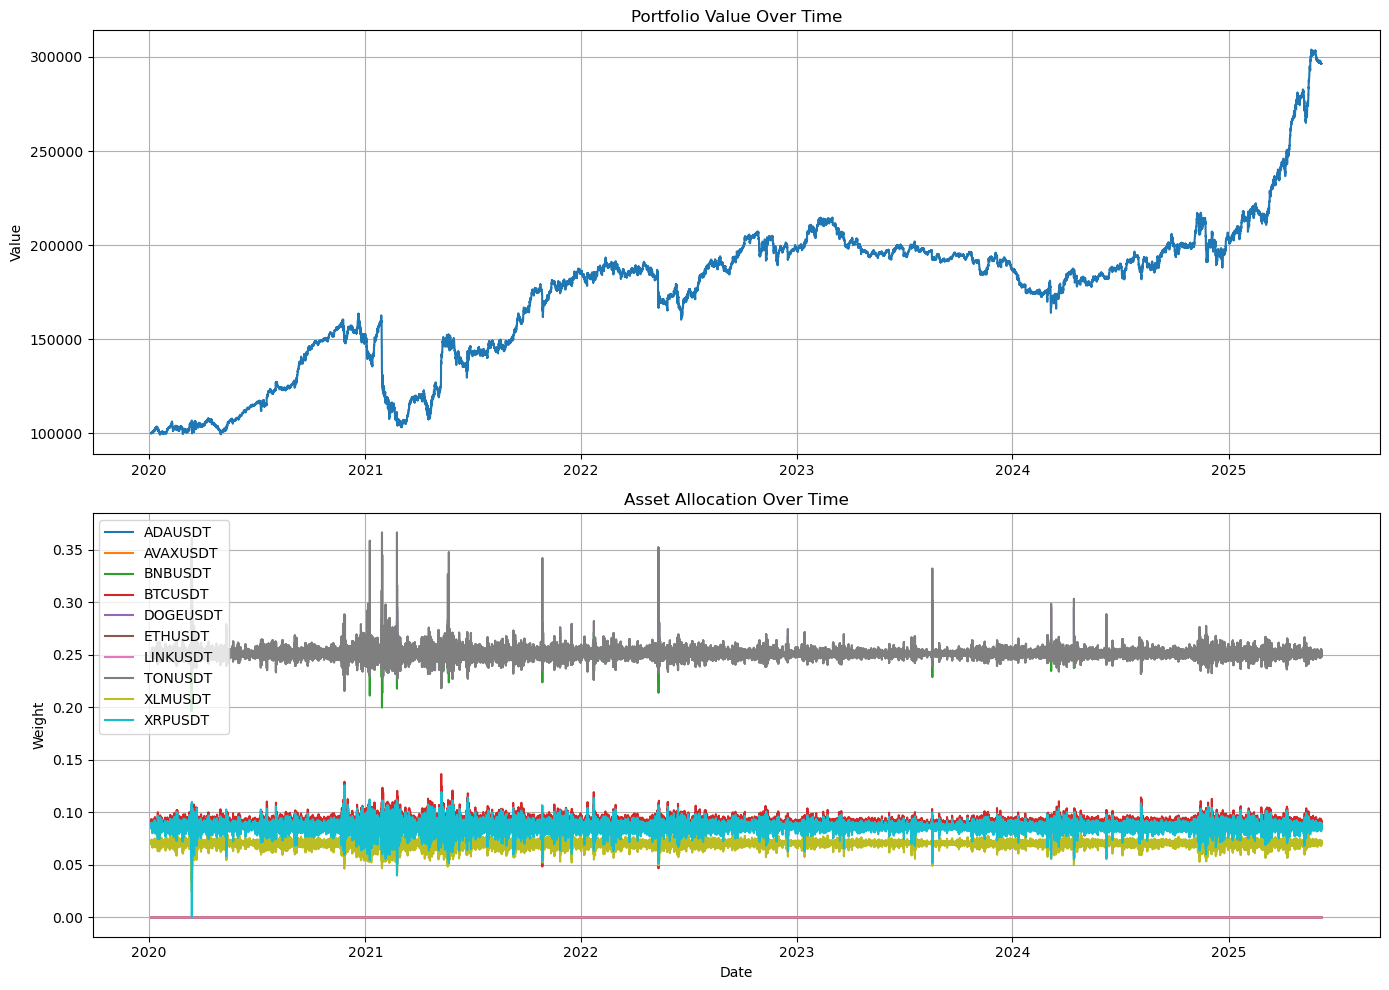


=== Performance Metrics ===
Total Return: 1.9635
Mean Return: 0.0000
Volatility: 0.0026
Sharpe Ratio: 0.0129
Max Drawdown: -0.3692
Avg Turnover: 0.0214
Total Transaction Costs: 127494.3183


In [71]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import gym
# from gym import spaces
# from stable_baselines3 import PPO
# from stable_baselines3.common.vec_env import DummyVecEnv

# # === DATA CLEANING ===
# df_hourly_pct_trade = df_hourly_pct_trade[(df_hourly_pct_trade != 0).any(axis=1)]
# df_hourly_pct_trade = df_hourly_pct_trade.dropna(how='all')

# # --- ENVIRONMENT CLASS ---
# class CryptoPortfolioEnv(gym.Env):
#     def __init__(self, returns_df, lookback=12):
#         super().__init__()
#         self.returns_df = returns_df
#         self.lookback = lookback
#         self.n_assets = returns_df.shape[1]
#         self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
#         self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(lookback, self.n_assets), dtype=np.float32)
#         self.reset()

#     def reset(self):
#         self.current_step = self.lookback
#         self.done = False
#         self.current_weights = np.ones(self.n_assets) / self.n_assets
#         return self._get_obs()

#     def _get_obs(self):
#         return self.returns_df.iloc[self.current_step - self.lookback:self.current_step].values

#     def step(self, action):
#         # --- Defensive normalization & diversification constraint ---
#         weights = np.clip(action, 0, 1)
#         max_weight = 0.4  # No single asset > 40% (tune as needed)
#         weights = np.clip(weights, 0, max_weight)
#         if np.sum(weights) == 0:
#             weights = np.ones_like(weights) / len(weights)
#         else:
#             weights = weights / np.sum(weights)
#         # --- Calculate return & reward ---
#         returns = self.returns_df.iloc[self.current_step].values
#         portfolio_return = np.dot(weights, returns)
#         # --- Sharpe-boosting reward: penalize volatility ---
#         LAMBDA = 0.5  # penalty coefficient, tune for your needs
#         if self.current_step >= self.lookback + 12:
#             recent_obs = self.returns_df.iloc[self.current_step-12:self.current_step]
#             port_returns_hist = recent_obs.dot(weights)
#             rolling_vol = np.std(port_returns_hist)
#             reward = portfolio_return - LAMBDA * rolling_vol
#         else:
#             reward = portfolio_return
#         # --- Step env ---
#         self.current_step += 1
#         self.done = self.current_step >= len(self.returns_df)
#         obs = self._get_obs() if not self.done else np.zeros((self.lookback, self.n_assets))
#         info = {'weights': weights}
#         return obs, reward, self.done, info

# # --- RL BACKTESTER CLASS ---
# class CryptoRLBacktester:
#     def __init__(self, returns_df, model=None, lookback=12, transaction_cost=0.001, initial_cash=100_000):
#         self.returns = returns_df.dropna()
#         self.lookback = lookback
#         self.transaction_cost = transaction_cost
#         self.initial_cash = initial_cash
#         self.tickers = returns_df.columns.tolist()
#         self.env = DummyVecEnv([lambda: CryptoPortfolioEnv(self.returns, lookback=lookback)])
#         if model is None:
#             self.model = PPO(
#                 "MlpPolicy", self.env, verbose=0,
#                 learning_rate=3e-4, ent_coef=0.01,
#                 gamma=0.99, gae_lambda=0.95,
#                 clip_range=0.2, n_steps=256, batch_size=64)
#         else:
#             self.model = model

#     def train_model(self, timesteps=20000):
#         self.model.learn(total_timesteps=timesteps)
#         return self.model

#     def run_backtest(self):
#         self.portfolio_values = [self.initial_cash]
#         self.weights_history = pd.DataFrame(np.nan, index=self.returns.index, columns=self.tickers)
#         self.transaction_costs = []
#         start_idx = self.lookback
#         current_weights = np.ones(len(self.tickers)) / len(self.tickers)
#         cash = self.initial_cash
#         for i in range(start_idx, len(self.returns)):
#             obs = self.returns.iloc[i-self.lookback:i].values
#             obs = obs.reshape(1, self.lookback, -1)
#             action, _ = self.model.predict(obs, deterministic=True)
#             # Defensive: Normalize weights & cap max weight
#             new_weights = np.clip(action[0], 0, 1)
#             max_weight = 0.4
#             new_weights = np.clip(new_weights, 0, max_weight)
#             if np.sum(new_weights) == 0:
#                 new_weights = np.ones_like(new_weights) / len(new_weights)
#             else:
#                 new_weights = new_weights / np.sum(new_weights)
#             turnover = np.sum(np.abs(new_weights - current_weights))
#             cost = self.transaction_cost * turnover * cash
#             cash -= cost
#             self.transaction_costs.append(cost)
#             portfolio_return = np.dot(new_weights, self.returns.iloc[i].values)
#             cash *= (1 + portfolio_return)
#             self.portfolio_values.append(cash)
#             self.weights_history.iloc[i] = new_weights
#             current_weights = new_weights

#         # Portfolio value series for pct_change
#         portfolio_index = [self.returns.index[start_idx-1]] + list(self.returns.index[start_idx:])
#         portfolio_values_series = pd.Series(self.portfolio_values, index=portfolio_index)
#         self.results = pd.DataFrame({
#             'Portfolio Value': portfolio_values_series,
#             'Returns': portfolio_values_series.pct_change().fillna(0)
#         })
#         return self.results

#     def plot_results(self):
#         fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
#         ax1.plot(self.results['Portfolio Value'])
#         ax1.set_title('Portfolio Value Over Time')
#         ax1.set_ylabel('Value')
#         ax1.grid(True)
#         for ticker in self.tickers:
#             ax2.plot(self.weights_history[ticker], label=ticker)
#         ax2.set_title('Asset Allocation Over Time')
#         ax2.set_xlabel('Date')
#         ax2.set_ylabel('Weight')
#         ax2.legend()
#         ax2.grid(True)
#         plt.tight_layout()
#         plt.show()

#     def get_metrics(self):
#         r = self.results['Returns']
#         value = self.results['Portfolio Value']
#         max_dd = (value / value.cummax() - 1).min()
#         return {
#             'Total Return': value.iloc[-1] / value.iloc[0] - 1,
#             'Mean Return': r.mean(),
#             'Volatility': r.std(),
#             'Sharpe Ratio': r.mean() / (r.std() + 1e-10),
#             'Max Drawdown': max_dd,
#             'Avg Turnover': np.mean(np.abs(self.weights_history.diff().dropna()).sum(axis=1)),
#             'Total Transaction Costs': sum(self.transaction_costs)
#         }

# # --- RUN RL TRAINING AND BACKTEST ---
# backtester = CryptoRLBacktester(df_hourly_pct_trade)
# backtester.train_model(timesteps=20000)  # Tune as needed!
# results = backtester.run_backtest()
# backtester.plot_results()
# metrics = backtester.get_metrics()
# print("\n=== Performance Metrics ===")
# for k, v in metrics.items():
#     print(f"{k}: {v:.4f}")


C:\Users\USER\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Step 12: weights = [0.24744749 0.01021011 0.24744749 0.         0.         0.
 0.         0.         0.24744749 0.24744749]
Step 13: weights = [0.  0.  0.  0.  0.  0.5 0.  0.5 0.  0. ]
Step 14: weights = [0.         0.16666667 0.16666667 0.16666667 0.         0.16666667
 0.         0.         0.16666667 0.16666667]
Step 15: weights = [0.21127054 0.         0.         0.         0.         0.
 0.2469213  0.27090403 0.27090403 0.        ]
Step 16: weights = [0.         0.33333334 0.         0.         0.33333334 0.
 0.         0.         0.         0.33333334]
Step 17: weights = [0.16891207 0.         0.15543966 0.         0.16891207 0.
 0.16891207 0.16891207 0.         0.16891207]
Step 18: weights = [0.         0.22212704 0.         0.22212704 0.02485544 0.08663646
 0.22212704 0.22212704 0.         0.        ]
Step 19: weights = [0.  0.  0.2 0.2 0.2 0.  0.  0.2 0.2 0. ]
Step 20: weights = [0.         0.1809685  0.16042107 0.1658171  0.1809685  0.1809685
 0.         0.         0.        

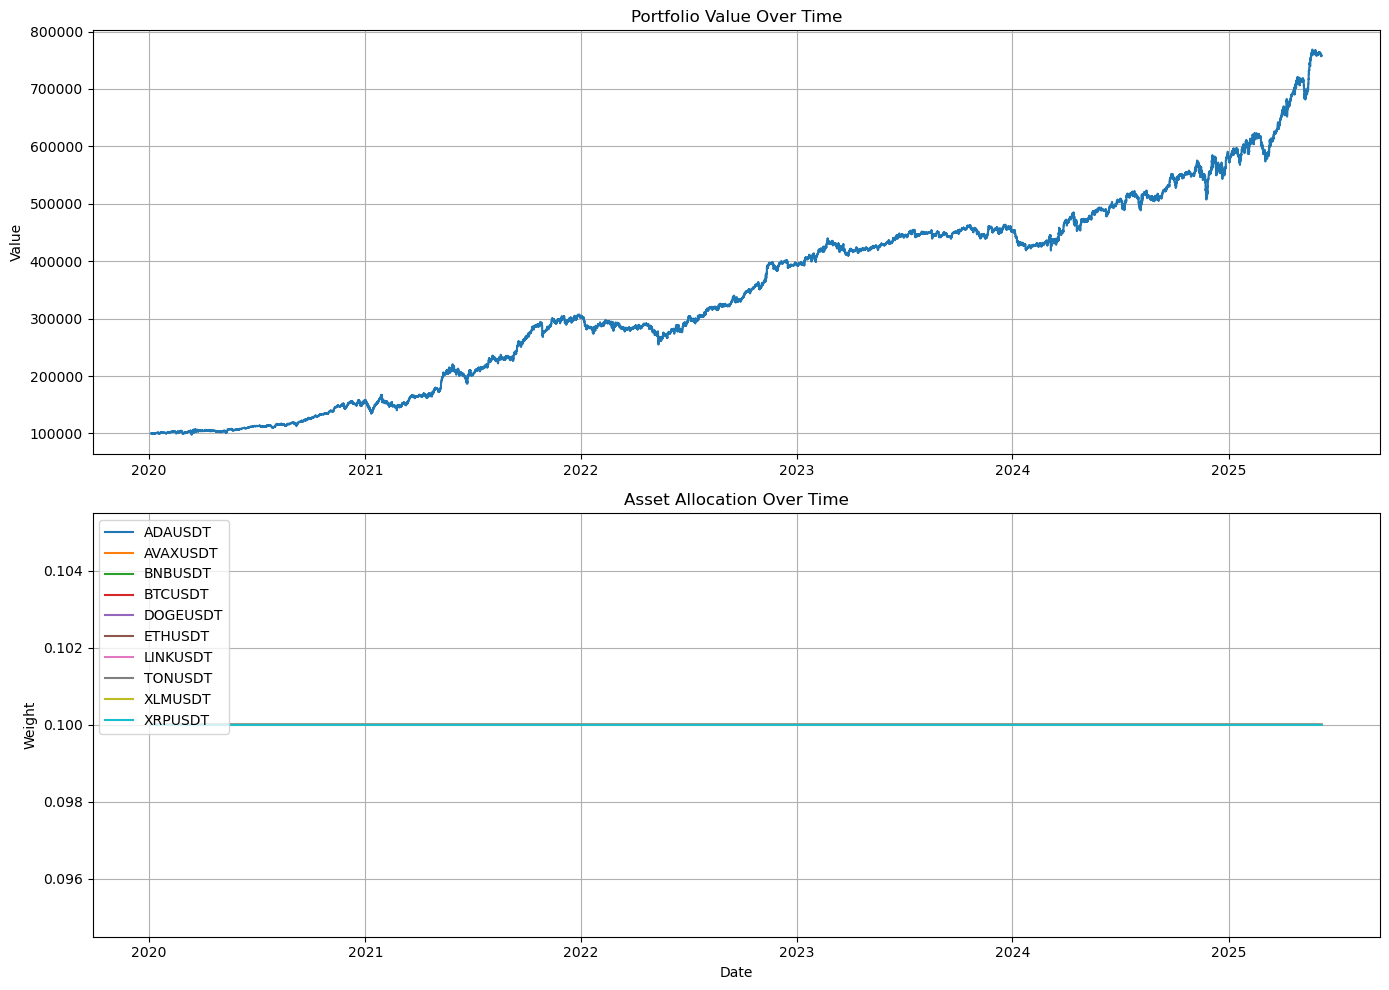


=== Performance Metrics ===
Total Return: 6.5777
Mean Return: 0.0001
Volatility: 0.0025
Sharpe Ratio: 0.0245
Max Drawdown: -0.1700
Avg Turnover: 0.0000
Total Transaction Costs: 0.0000


In [75]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import gym
# from gym import spaces
# from stable_baselines3 import PPO
# from stable_baselines3.common.vec_env import DummyVecEnv

# # === DATA CLEANING ===
# df_hourly_pct_trade = df_hourly_pct_trade[(df_hourly_pct_trade != 0).any(axis=1)]
# df_hourly_pct_trade = df_hourly_pct_trade.dropna(how='all')

# # --- ENVIRONMENT CLASS ---
# class CryptoPortfolioEnv(gym.Env):
#     def __init__(self, returns_df, lookback=12):
#         super().__init__()
#         self.returns_df = returns_df
#         self.lookback = lookback
#         self.n_assets = returns_df.shape[1]
#         self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
#         self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(lookback, self.n_assets), dtype=np.float32)
#         self.reset()

#     def reset(self):
#         self.current_step = self.lookback
#         self.done = False
#         self.current_weights = np.ones(self.n_assets) / self.n_assets
#         self.prev_weights = np.ones(self.n_assets) / self.n_assets
#         return self._get_obs()

#     def _get_obs(self):
#         return self.returns_df.iloc[self.current_step - self.lookback:self.current_step].values

#     def step(self, action):
#         # --- Defensive normalization & diversification constraint ---
#         weights = np.clip(action, 0, 1)
#         max_weight = 0.3  # No single asset > 30%
#         weights = np.clip(weights, 0, max_weight)
#         if np.sum(weights) == 0:
#             weights = np.ones_like(weights) / len(weights)
#         else:
#             weights = weights / np.sum(weights)
        
#         returns = self.returns_df.iloc[self.current_step].values
#         portfolio_return = np.dot(weights, returns)
        
#         # --- Rolling volatility penalty ---
#         LAMBDA = 0.05
#         # --- Turnover penalty ---
#         TURNOVER_PENALTY = 0.01
#         turnover = np.sum(np.abs(weights - self.prev_weights))
#         self.prev_weights = weights.copy()
        
#         if self.current_step >= self.lookback + 12:
#             recent_obs = self.returns_df.iloc[self.current_step-12:self.current_step]
#             port_returns_hist = recent_obs.dot(weights)
#             rolling_vol = np.std(port_returns_hist)
#             reward = (
#                 portfolio_return
#                 - LAMBDA * rolling_vol
#                 - TURNOVER_PENALTY * turnover
#             )
#         else:
#             reward = portfolio_return
        
#         # --- Entropy (diversity) reward ---
#         diversity = -np.sum(weights * np.log(weights + 1e-8))
#         reward = reward + 0.01 * diversity

#         # Print weights for the first 10 steps
#         if self.current_step < self.lookback + 10:
#             print(f"Step {self.current_step}: weights = {weights}")

#         self.current_step += 1
#         self.done = self.current_step >= len(self.returns_df)
#         obs = self._get_obs() if not self.done else np.zeros((self.lookback, self.n_assets))
#         info = {'weights': weights}
#         return obs, reward, self.done, info

# # --- RL BACKTESTER CLASS ---
# class CryptoRLBacktester:
#     def __init__(self, returns_df, model=None, lookback=12, transaction_cost=0.001, initial_cash=100_000):
#         self.returns = returns_df.dropna()
#         self.lookback = lookback
#         self.transaction_cost = transaction_cost
#         self.initial_cash = initial_cash
#         self.tickers = returns_df.columns.tolist()
#         self.env = DummyVecEnv([lambda: CryptoPortfolioEnv(self.returns, lookback=lookback)])
#         if model is None:
#             self.model = PPO(
#                 "MlpPolicy", self.env, verbose=0,
#                 learning_rate=3e-4, ent_coef=0.05,  # Higher entropy coef for more exploration
#                 gamma=0.99, gae_lambda=0.95,
#                 clip_range=0.2, n_steps=256, batch_size=64)
#         else:
#             self.model = model

#     def train_model(self, timesteps=50000):  # Try 50,000 or even 100,000 for more robust learning
#         self.model.learn(total_timesteps=timesteps)
#         return self.model

#     def run_backtest(self):
#         self.portfolio_values = [self.initial_cash]
#         self.weights_history = pd.DataFrame(np.nan, index=self.returns.index, columns=self.tickers)
#         self.transaction_costs = []
#         start_idx = self.lookback
#         current_weights = np.ones(len(self.tickers)) / len(self.tickers)
#         cash = self.initial_cash
#         for i in range(start_idx, len(self.returns)):
#             obs = self.returns.iloc[i-self.lookback:i].values
#             obs = obs.reshape(1, self.lookback, -1)
#             action, _ = self.model.predict(obs, deterministic=True)
#             # Defensive: Normalize weights & cap max weight
#             new_weights = np.clip(action[0], 0, 1)
#             max_weight = 0.3
#             new_weights = np.clip(new_weights, 0, max_weight)
#             if np.sum(new_weights) == 0:
#                 new_weights = np.ones_like(new_weights) / len(new_weights)
#             else:
#                 new_weights = new_weights / np.sum(new_weights)
#             turnover = np.sum(np.abs(new_weights - current_weights))
#             cost = self.transaction_cost * turnover * cash
#             cash -= cost
#             self.transaction_costs.append(cost)
#             portfolio_return = np.dot(new_weights, self.returns.iloc[i].values)
#             cash *= (1 + portfolio_return)
#             self.portfolio_values.append(cash)
#             self.weights_history.iloc[i] = new_weights
#             current_weights = new_weights

#         # Portfolio value series for pct_change
#         portfolio_index = [self.returns.index[start_idx-1]] + list(self.returns.index[start_idx:])
#         portfolio_values_series = pd.Series(self.portfolio_values, index=portfolio_index)
#         self.results = pd.DataFrame({
#             'Portfolio Value': portfolio_values_series,
#             'Returns': portfolio_values_series.pct_change().fillna(0)
#         })
#         return self.results

#     def plot_results(self):
#         fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
#         ax1.plot(self.results['Portfolio Value'])
#         ax1.set_title('Portfolio Value Over Time')
#         ax1.set_ylabel('Value')
#         ax1.grid(True)
#         for ticker in self.tickers:
#             ax2.plot(self.weights_history[ticker], label=ticker)
#         ax2.set_title('Asset Allocation Over Time')
#         ax2.set_xlabel('Date')
#         ax2.set_ylabel('Weight')
#         ax2.legend()
#         ax2.grid(True)
#         plt.tight_layout()
#         plt.show()

#     def get_metrics(self):
#         r = self.results['Returns']
#         value = self.results['Portfolio Value']
#         max_dd = (value / value.cummax() - 1).min()
#         return {
#             'Total Return': value.iloc[-1] / value.iloc[0] - 1,
#             'Mean Return': r.mean(),
#             'Volatility': r.std(),
#             'Sharpe Ratio': r.mean() / (r.std() + 1e-10),
#             'Max Drawdown': max_dd,
#             'Avg Turnover': np.mean(np.abs(self.weights_history.diff().dropna()).sum(axis=1)),
#             'Total Transaction Costs': sum(self.transaction_costs)
#         }

# # --- RUN RL TRAINING AND BACKTEST ---
# backtester = CryptoRLBacktester(df_hourly_pct_trade)
# backtester.train_model(timesteps=50000)  # Or higher
# results = backtester.run_backtest()
# backtester.plot_results()
# metrics = backtester.get_metrics()
# print("\n=== Performance Metrics ===")
# for k, v in metrics.items():
#     print(f"{k}: {v:.4f}")


C:\Users\USER\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Step 12: weights = [0.    0.    0.    0.    0.305 0.    0.305 0.175 0.    0.215], reward = 0.00127
Step 13: weights = [0.198 0.    0.012 0.198 0.    0.198 0.198 0.198 0.    0.   ], reward = -0.00005
Step 14: weights = [0.    0.    0.178 0.144 0.119 0.    0.    0.    0.28  0.28 ], reward = 0.00001
Step 15: weights = [0.015 0.    0.    0.    0.286 0.    0.    0.127 0.286 0.286], reward = 0.00003
Step 16: weights = [0.2 0.  0.  0.  0.2 0.  0.2 0.2 0.  0.2], reward = -0.00033
Step 17: weights = [0.145 0.    0.145 0.144 0.145 0.145 0.145 0.    0.    0.132], reward = -0.00048
Step 18: weights = [0.    0.    0.    0.263 0.281 0.    0.281 0.    0.    0.176], reward = 0.00045
Step 19: weights = [0.374 0.177 0.    0.374 0.    0.    0.    0.    0.    0.075], reward = 0.00235
Step 20: weights = [0.    0.    0.147 0.    0.158 0.    0.29  0.    0.    0.405], reward = 0.00343
Step 21: weights = [0.    0.333 0.    0.    0.    0.    0.    0.333 0.333 0.   ], reward = -0.00032
Step 12: weights = [0.021 

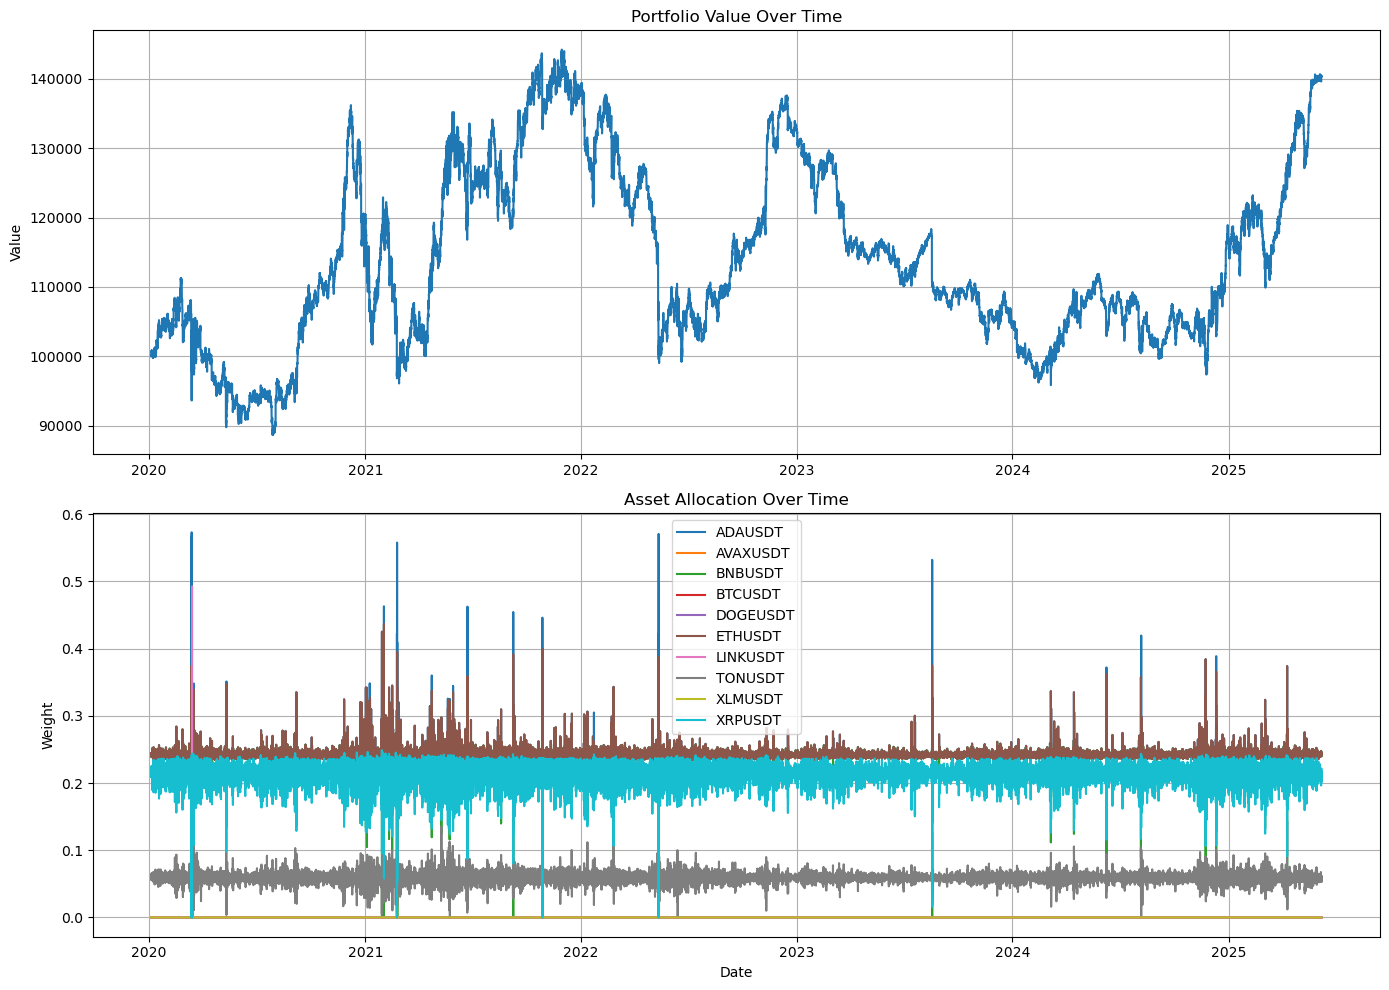


=== Performance Metrics ===
Total Return: 0.4034
Mean Return: 0.0000
Volatility: 0.0030
Sharpe Ratio: 0.0047
Max Drawdown: -0.3354
Avg Turnover: 0.0334
Total Transaction Costs: 135142.6952


In [77]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import gym
# from gym import spaces
# from stable_baselines3 import PPO
# from stable_baselines3.common.vec_env import DummyVecEnv

# # === DATA CLEANING ===
# df_hourly_pct_trade = df_hourly_pct_trade[(df_hourly_pct_trade != 0).any(axis=1)]
# df_hourly_pct_trade = df_hourly_pct_trade.dropna(how='all')

# # --- ENVIRONMENT CLASS ---
# class CryptoPortfolioEnv(gym.Env):
#     def __init__(self, returns_df, lookback=12):
#         super().__init__()
#         self.returns_df = returns_df
#         self.lookback = lookback
#         self.n_assets = returns_df.shape[1]
#         self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
#         self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(lookback, self.n_assets), dtype=np.float32)
#         self.reset()

#     def reset(self):
#         self.current_step = self.lookback
#         self.done = False
#         self.current_weights = np.ones(self.n_assets) / self.n_assets
#         return self._get_obs()

#     def _get_obs(self):
#         return self.returns_df.iloc[self.current_step - self.lookback:self.current_step].values

#     def step(self, action):
#         # --- Defensive normalization & diversification constraint ---
#         weights = np.clip(action, 0, 1)
#         max_weight = 0.5  # Allow up to 50% in one asset (encourage concentration if wanted)
#         weights = np.clip(weights, 0, max_weight)
#         if np.sum(weights) == 0:
#             weights = np.ones_like(weights) / len(weights)
#         else:
#             weights = weights / np.sum(weights)

#         returns = self.returns_df.iloc[self.current_step].values
#         portfolio_return = np.dot(weights, returns)
#         equal_weight_return = np.mean(returns)
#         reward = portfolio_return - equal_weight_return

#         # Print weights for the first 10 steps
#         if self.current_step < self.lookback + 10:
#             print(f"Step {self.current_step}: weights = {np.round(weights,3)}, reward = {reward:.5f}")

#         self.current_step += 1
#         self.done = self.current_step >= len(self.returns_df)
#         obs = self._get_obs() if not self.done else np.zeros((self.lookback, self.n_assets))
#         info = {'weights': weights}
#         return obs, reward, self.done, info

# # --- RL BACKTESTER CLASS ---
# class CryptoRLBacktester:
#     def __init__(self, returns_df, model=None, lookback=12, transaction_cost=0.001, initial_cash=100_000):
#         self.returns = returns_df.dropna()
#         self.lookback = lookback
#         self.transaction_cost = transaction_cost
#         self.initial_cash = initial_cash
#         self.tickers = returns_df.columns.tolist()
#         self.env = DummyVecEnv([lambda: CryptoPortfolioEnv(self.returns, lookback=lookback)])
#         if model is None:
#             self.model = PPO(
#                 "MlpPolicy", self.env, verbose=0,
#                 learning_rate=3e-4, ent_coef=0.05,
#                 gamma=0.99, gae_lambda=0.95,
#                 clip_range=0.2, n_steps=256, batch_size=64)
#         else:
#             self.model = model

#     def train_model(self, timesteps=50000):  # Increase for better convergence
#         self.model.learn(total_timesteps=timesteps)
#         return self.model

#     def run_backtest(self):
#         self.portfolio_values = [self.initial_cash]
#         self.weights_history = pd.DataFrame(np.nan, index=self.returns.index, columns=self.tickers)
#         self.transaction_costs = []
#         start_idx = self.lookback
#         current_weights = np.ones(len(self.tickers)) / len(self.tickers)
#         cash = self.initial_cash
#         for i in range(start_idx, len(self.returns)):
#             obs = self.returns.iloc[i-self.lookback:i].values
#             obs = obs.reshape(1, self.lookback, -1)
#             action, _ = self.model.predict(obs, deterministic=True)
#             # Defensive: Normalize weights & cap max weight
#             new_weights = np.clip(action[0], 0, 1)
#             max_weight = 0.5
#             new_weights = np.clip(new_weights, 0, max_weight)
#             if np.sum(new_weights) == 0:
#                 new_weights = np.ones_like(new_weights) / len(new_weights)
#             else:
#                 new_weights = new_weights / np.sum(new_weights)
#             turnover = np.sum(np.abs(new_weights - current_weights))
#             cost = self.transaction_cost * turnover * cash
#             cash -= cost
#             self.transaction_costs.append(cost)
#             portfolio_return = np.dot(new_weights, self.returns.iloc[i].values)
#             cash *= (1 + portfolio_return)
#             self.portfolio_values.append(cash)
#             self.weights_history.iloc[i] = new_weights
#             current_weights = new_weights

#         # Portfolio value series for pct_change
#         portfolio_index = [self.returns.index[start_idx-1]] + list(self.returns.index[start_idx:])
#         portfolio_values_series = pd.Series(self.portfolio_values, index=portfolio_index)
#         self.results = pd.DataFrame({
#             'Portfolio Value': portfolio_values_series,
#             'Returns': portfolio_values_series.pct_change().fillna(0)
#         })
#         return self.results

#     def plot_results(self):
#         fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
#         ax1.plot(self.results['Portfolio Value'])
#         ax1.set_title('Portfolio Value Over Time')
#         ax1.set_ylabel('Value')
#         ax1.grid(True)
#         for ticker in self.tickers:
#             ax2.plot(self.weights_history[ticker], label=ticker)
#         ax2.set_title('Asset Allocation Over Time')
#         ax2.set_xlabel('Date')
#         ax2.set_ylabel('Weight')
#         ax2.legend()
#         ax2.grid(True)
#         plt.tight_layout()
#         plt.show()

#     def get_metrics(self):
#         r = self.results['Returns']
#         value = self.results['Portfolio Value']
#         max_dd = (value / value.cummax() - 1).min()
#         return {
#             'Total Return': value.iloc[-1] / value.iloc[0] - 1,
#             'Mean Return': r.mean(),
#             'Volatility': r.std(),
#             'Sharpe Ratio': r.mean() / (r.std() + 1e-10),
#             'Max Drawdown': max_dd,
#             'Avg Turnover': np.mean(np.abs(self.weights_history.diff().dropna()).sum(axis=1)),
#             'Total Transaction Costs': sum(self.transaction_costs)
#         }

# # --- RUN RL TRAINING AND BACKTEST ---
# backtester = CryptoRLBacktester(df_hourly_pct_trade)
# backtester.train_model(timesteps=50000)  # Try 50k, 100k or more for better learning
# results = backtester.run_backtest()
# backtester.plot_results()
# metrics = backtester.get_metrics()
# print("\n=== Performance Metrics ===")
# for k, v in metrics.items():
#     print(f"{k}: {v:.4f}")


C:\Users\USER\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Step 7: weights = [0.    0.082 0.22  0.15  0.    0.    0.274 0.    0.274 0.   ], reward = 0.00301
Step 8: weights = [0.    0.027 0.    0.272 0.    0.272 0.    0.    0.272 0.156], reward = 0.00417
Step 9: weights = [0.    0.    0.187 0.187 0.187 0.187 0.187 0.    0.064 0.   ], reward = -0.00003
Step 10: weights = [0.    0.    0.    0.    0.29  0.    0.    0.117 0.296 0.296], reward = 0.00572
Step 11: weights = [0.    0.    0.249 0.038 0.329 0.055 0.329 0.    0.    0.   ], reward = 0.00608
Step 12: weights = [0.228 0.    0.14  0.    0.    0.    0.316 0.316 0.    0.   ], reward = 0.00393
Step 13: weights = [0.128 0.197 0.268 0.142 0.    0.058 0.    0.    0.207 0.   ], reward = 0.00316
Step 14: weights = [0.151 0.151 0.087 0.    0.01  0.151 0.151 0.151 0.151 0.   ], reward = 0.00072
Step 15: weights = [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], reward = 0.02006
Step 16: weights = [0.168 0.    0.168 0.168 0.168 0.097 0.    0.    0.084 0.146], reward = -0.00082
Step 7: weights = [0.25 0.25 0.   0.25 0.

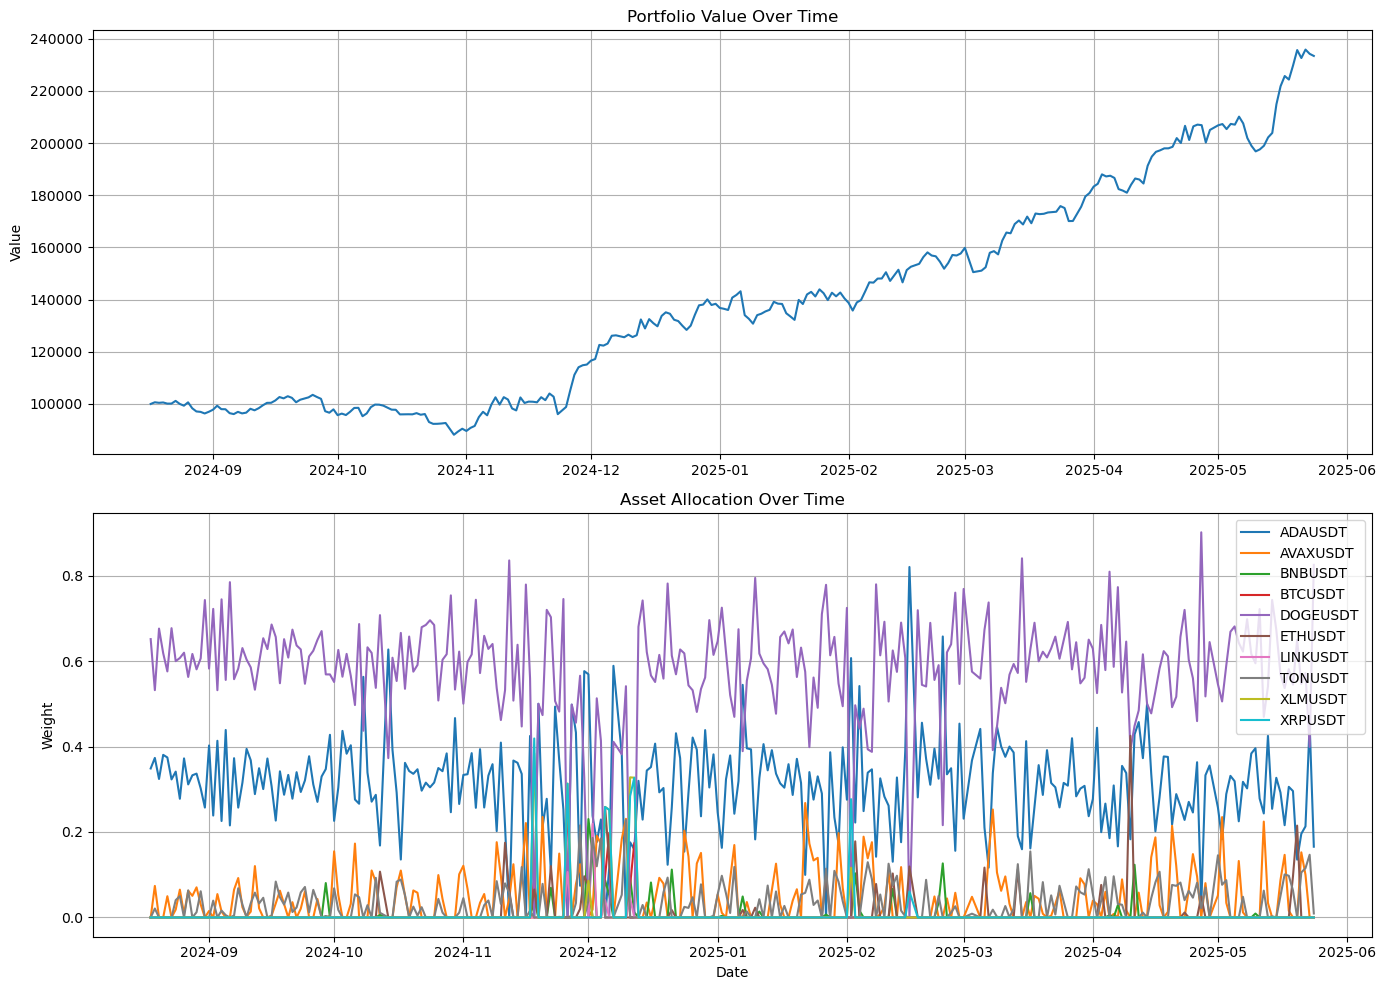


=== Performance Metrics ===
Total Return: 1.3340
Mean Return: 0.0033
Volatility: 0.0184
Sharpe Ratio: 0.1767
Max Drawdown: -0.1478
Avg Turnover: 0.4052
Total Transaction Costs: 15344.9770


In [81]:
# # --- 2. RL ENVIRONMENT FOR DAILY REBALANCING ---
# class CryptoPortfolioDailyEnv(gym.Env):
#     def __init__(self, returns_df, lookback=7):
#         super().__init__()
#         self.returns_df = returns_df
#         self.lookback = lookback
#         self.n_assets = returns_df.shape[1]
#         self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
#         self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(lookback, self.n_assets), dtype=np.float32)
#         self.reset()

#     def reset(self):
#         self.current_step = self.lookback
#         self.done = False
#         self.current_weights = np.ones(self.n_assets) / self.n_assets
#         return self._get_obs()

#     def _get_obs(self):
#         return self.returns_df.iloc[self.current_step - self.lookback:self.current_step].values

#     def step(self, action):
#         weights = np.clip(action, 0, 1)
#         max_weight = 0.5  # No more than 50% in any asset
#         weights = np.clip(weights, 0, max_weight)
#         if np.sum(weights) == 0:
#             weights = np.ones_like(weights) / len(weights)
#         else:
#             weights = weights / np.sum(weights)

#         returns = self.returns_df.iloc[self.current_step].values
#         portfolio_return = np.dot(weights, returns)
#         equal_weight_return = np.mean(returns)
#         reward = portfolio_return - equal_weight_return  # Alpha vs benchmark

#         if self.current_step < self.lookback + 10:
#             print(f"Step {self.current_step}: weights = {np.round(weights, 3)}, reward = {reward:.5f}")

#         self.current_step += 1
#         self.done = self.current_step >= len(self.returns_df)
#         obs = self._get_obs() if not self.done else np.zeros((self.lookback, self.n_assets))
#         info = {'weights': weights}
#         return obs, reward, self.done, info

# # --- 3. RL BACKTESTER CLASS ---
# class CryptoRLBacktester:
#     def __init__(self, returns_df, model=None, lookback=7, transaction_cost=0.001, initial_cash=100_000):
#         self.returns = returns_df.dropna()
#         self.lookback = lookback
#         self.transaction_cost = transaction_cost
#         self.initial_cash = initial_cash
#         self.tickers = returns_df.columns.tolist()
#         self.env = DummyVecEnv([lambda: CryptoPortfolioDailyEnv(self.returns, lookback=lookback)])
#         if model is None:
#             self.model = PPO(
#                 "MlpPolicy", self.env, verbose=0,
#                 learning_rate=3e-4, ent_coef=0.05,
#                 gamma=0.99, gae_lambda=0.95,
#                 clip_range=0.2, n_steps=128, batch_size=32)
#         else:
#             self.model = model

#     def train_model(self, timesteps=20000):  # 20k+ is good for daily
#         self.model.learn(total_timesteps=timesteps)
#         return self.model

#     def run_backtest(self):
#         self.portfolio_values = [self.initial_cash]
#         self.weights_history = pd.DataFrame(np.nan, index=self.returns.index, columns=self.tickers)
#         self.transaction_costs = []
#         start_idx = self.lookback
#         current_weights = np.ones(len(self.tickers)) / len(self.tickers)
#         cash = self.initial_cash
#         for i in range(start_idx, len(self.returns)):
#             obs = self.returns.iloc[i-self.lookback:i].values
#             obs = obs.reshape(1, self.lookback, -1)
#             action, _ = self.model.predict(obs, deterministic=True)
#             new_weights = np.clip(action[0], 0, 1)
#             max_weight = 0.5
#             new_weights = np.clip(new_weights, 0, max_weight)
#             if np.sum(new_weights) == 0:
#                 new_weights = np.ones_like(new_weights) / len(new_weights)
#             else:
#                 new_weights = new_weights / np.sum(new_weights)
#             turnover = np.sum(np.abs(new_weights - current_weights))
#             cost = self.transaction_cost * turnover * cash
#             cash -= cost
#             self.transaction_costs.append(cost)
#             portfolio_return = np.dot(new_weights, self.returns.iloc[i].values)
#             cash *= (1 + portfolio_return)
#             self.portfolio_values.append(cash)
#             self.weights_history.iloc[i] = new_weights
#             current_weights = new_weights

#         portfolio_index = [self.returns.index[start_idx-1]] + list(self.returns.index[start_idx:])
#         portfolio_values_series = pd.Series(self.portfolio_values, index=portfolio_index)
#         self.results = pd.DataFrame({
#             'Portfolio Value': portfolio_values_series,
#             'Returns': portfolio_values_series.pct_change().fillna(0)
#         })
#         return self.results

#     def plot_results(self):
#         fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
#         ax1.plot(self.results['Portfolio Value'])
#         ax1.set_title('Portfolio Value Over Time')
#         ax1.set_ylabel('Value')
#         ax1.grid(True)
#         for ticker in self.tickers:
#             ax2.plot(self.weights_history[ticker], label=ticker)
#         ax2.set_title('Asset Allocation Over Time')
#         ax2.set_xlabel('Date')
#         ax2.set_ylabel('Weight')
#         ax2.legend()
#         ax2.grid(True)
#         plt.tight_layout()
#         plt.show()

#     def get_metrics(self):
#         r = self.results['Returns']
#         value = self.results['Portfolio Value']
#         max_dd = (value / value.cummax() - 1).min()
#         return {
#             'Total Return': value.iloc[-1] / value.iloc[0] - 1,
#             'Mean Return': r.mean(),
#             'Volatility': r.std(),
#             'Sharpe Ratio': r.mean() / (r.std() + 1e-10),
#             'Max Drawdown': max_dd,
#             'Avg Turnover': np.mean(np.abs(self.weights_history.diff().dropna()).sum(axis=1)),
#             'Total Transaction Costs': sum(self.transaction_costs)
#         }

# # --- 4. TRAIN AND RUN RL BACKTEST ---
# backtester = CryptoRLBacktester(df_daily_pct_trade)
# backtester.train_model(timesteps=20000)  # Try higher for more convergence
# results = backtester.run_backtest()
# backtester.plot_results()
# metrics = backtester.get_metrics()
# print("\n=== Performance Metrics ===")
# for k, v in metrics.items():
#     print(f"{k}: {v:.4f}")


In [89]:
# import pandas as pd
# import numpy as np

# # --- Load the trade log ---
# df = pd.read_csv(r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\combined_trade_log_06.27.csv")

# # --- Convert 'Entry Time' to datetime ---
# df['Entry Time'] = pd.to_datetime(df['Entry Time'])

# # --- Calculate PnL as percent of notional ---
# fixed_notional = 200_000.0  # Change if needed
# df['PnL_pct'] = df['PnL (USD)'] / fixed_notional

# # --- Floor 'Entry Time' to daily and get ticker ---
# df['dt_day'] = df['Entry Time'].dt.floor('D')

# # --- Pivot into daily returns time series: rows = date, cols = ticker ---
# df_daily_pct_trade = (
#     df.groupby(['dt_day', 'Ticker'])['PnL_pct']
#     .sum()
#     .unstack(fill_value=0.0)
#     .sort_index()
# )


In [103]:
# import pandas as pd
# import numpy as np

# # --- Load trade log ---
# df = pd.read_csv(r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\combined_trade_log_06.27.csv")

# # --- Convert 'Entry Time' to datetime ---
# df['Entry Time'] = pd.to_datetime(df['Entry Time'])

# # --- Calculate PnL as percent of notional ---
# fixed_notional = 200_000.0
# df['PnL_pct'] = df['PnL (USD)'] / fixed_notional

# # --- Floor to daily and pivot to timeseries ---
# df['dt_day'] = df['Entry Time'].dt.floor('D')
# df_daily_pct_trade = (
#     df.groupby(['dt_day', 'Ticker'])['PnL_pct']
#     .sum()
#     .unstack(fill_value=0.0)
#     .sort_index()
# )

# # --- Fill the full calendar range with zeros ---
# full_range = pd.date_range(
#     start=df_daily_pct_trade.index.min().floor('D'),
#     end=df_daily_pct_trade.index.max().ceil('D'),
#     freq='D'
# )
# df_daily_pct_trade = df_daily_pct_trade.reindex(full_range, fill_value=0)
# print(df_daily_pct_trade.index.min(), df_daily_pct_trade.index.max())
# print(df_daily_pct_trade.head(3))


2020-01-03 00:00:00 2025-06-07 00:00:00
Ticker       ADAUSDT  AVAXUSDT   BNBUSDT   BTCUSDT  DOGEUSDT   ETHUSDT  \
2020-01-03 -0.000296       0.0  0.006160  0.000929  0.003764  0.002306   
2020-01-04  0.007841       0.0 -0.011252  0.004157  0.007639 -0.001641   
2020-01-05 -0.009211       0.0  0.013201 -0.007319  0.009831 -0.002488   

Ticker      LINKUSDT  TONUSDT   XLMUSDT   XRPUSDT  
2020-01-03  0.000000      0.0  0.001561 -0.000844  
2020-01-04  0.002171      0.0 -0.006831  0.015025  
2020-01-05 -0.003787      0.0  0.006773  0.001075  


In [105]:
# import gym
# from gym import spaces
# from stable_baselines3 import PPO
# from stable_baselines3.common.vec_env import DummyVecEnv
# import matplotlib.pyplot as plt

# class CryptoPortfolioDailyEnv(gym.Env):
#     def __init__(self, returns_df, lookback=30, cost_penalty=0.002):
#         super().__init__()
#         self.returns_df = returns_df
#         self.lookback = lookback
#         self.n_assets = returns_df.shape[1]
#         self.cost_penalty = cost_penalty
#         self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
#         self.observation_space = spaces.Box(low=-5, high=5, shape=(lookback, self.n_assets), dtype=np.float32)
#         self.reset()

#     def reset(self):
#         self.current_step = self.lookback
#         self.done = False
#         self.current_weights = np.ones(self.n_assets) / self.n_assets
#         self.returns_history = []
#         return self._get_obs()

#     def _get_obs(self):
#         obs = self.returns_df.iloc[self.current_step - self.lookback:self.current_step].values
#         obs = (obs - np.mean(obs, axis=0)) / (np.std(obs, axis=0) + 1e-8)  # Normalize per asset
#         return obs

#     def step(self, action):
#         weights = np.clip(action, 0, 1)
#         max_weight = 0.5
#         weights = np.clip(weights, 0, max_weight)
#         weights = weights / np.sum(weights) if np.sum(weights) > 0 else np.ones_like(weights) / len(weights)

#         turnover = np.sum(np.abs(weights - self.current_weights))
#         returns = self.returns_df.iloc[self.current_step].values
#         portfolio_return = np.dot(weights, returns)
#         self.returns_history.append(portfolio_return)
#         self.current_weights = weights

#         # Sharpe-based reward (last 30 days)
#         sharpe_reward = 0
#         if len(self.returns_history) >= 30:
#             r = np.array(self.returns_history[-30:])
#             if r.std() > 0:
#                 sharpe_reward = r.mean() / (r.std() + 1e-8)
#         reward = sharpe_reward - self.cost_penalty * turnover

#         self.current_step += 1
#         self.done = self.current_step >= len(self.returns_df)
#         obs = self._get_obs() if not self.done else np.zeros((self.lookback, self.n_assets))
#         info = {'weights': weights}
#         return obs, reward, self.done, info

# class CryptoRLBacktester:
#     def __init__(self, returns_df, model=None, lookback=30, transaction_cost=0.001, initial_cash=100_000):
#         self.returns = returns_df.copy()
#         self.lookback = lookback
#         self.transaction_cost = transaction_cost
#         self.initial_cash = initial_cash
#         self.tickers = returns_df.columns.tolist()
#         self.env = DummyVecEnv([lambda: CryptoPortfolioDailyEnv(self.returns, lookback=lookback)])
#         if model is None:
#             self.model = PPO(
#                 "MlpPolicy", self.env, verbose=0,
#                 learning_rate=3e-4, ent_coef=0.05,
#                 gamma=0.99, gae_lambda=0.95,
#                 clip_range=0.2, n_steps=128, batch_size=32)
#         else:
#             self.model = model

#     def train_model(self, timesteps=100_000):
#         self.model.learn(total_timesteps=timesteps)
#         return self.model

#     def run_backtest(self):
#         self.portfolio_values = [self.initial_cash]
#         self.weights_history = pd.DataFrame(np.nan, index=self.returns.index, columns=self.tickers)
#         self.transaction_costs = []
#         start_idx = self.lookback
#         current_weights = np.ones(len(self.tickers)) / len(self.tickers)
#         cash = self.initial_cash
#         for i in range(start_idx, len(self.returns)):
#             obs = self.returns.iloc[i-self.lookback:i].values
#             obs = (obs - np.mean(obs, axis=0)) / (np.std(obs, axis=0) + 1e-8)  # Normalize!
#             obs = obs.reshape(1, self.lookback, -1)
#             action, _ = self.model.predict(obs, deterministic=True)
#             new_weights = np.clip(action[0], 0, 1)
#             max_weight = 0.5
#             new_weights = np.clip(new_weights, 0, max_weight)
#             new_weights = new_weights / np.sum(new_weights) if np.sum(new_weights) > 0 else np.ones_like(new_weights) / len(new_weights)
#             turnover = np.sum(np.abs(new_weights - current_weights))
#             cost = self.transaction_cost * turnover * cash
#             cash -= cost
#             self.transaction_costs.append(cost)
#             portfolio_return = np.dot(new_weights, self.returns.iloc[i].values)
#             cash *= (1 + portfolio_return)
#             self.portfolio_values.append(cash)
#             self.weights_history.iloc[i] = new_weights
#             current_weights = new_weights

#         portfolio_index = [self.returns.index[start_idx-1]] + list(self.returns.index[start_idx:])
#         portfolio_values_series = pd.Series(self.portfolio_values, index=portfolio_index)
#         self.results = pd.DataFrame({
#             'Portfolio Value': portfolio_values_series,
#             'Returns': portfolio_values_series.pct_change().fillna(0)
#         })
#         return self.results

#     def plot_results(self):
#         fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
#         ax1.plot(self.results['Portfolio Value'])
#         ax1.set_title('Portfolio Value Over Time')
#         ax1.set_ylabel('Value')
#         ax1.grid(True)
#         for ticker in self.tickers:
#             ax2.plot(self.weights_history[ticker], label=ticker)
#         ax2.set_title('Asset Allocation Over Time')
#         ax2.set_xlabel('Date')
#         ax2.set_ylabel('Weight')
#         ax2.legend()
#         ax2.grid(True)
#         plt.tight_layout()
#         plt.show()

#     def get_metrics(self):
#         r = self.results['Returns']
#         value = self.results['Portfolio Value']
#         max_dd = (value / value.cummax() - 1).min()
#         return {
#             'Total Return': value.iloc[-1] / value.iloc[0] - 1,
#             'Mean Return': r.mean(),
#             'Volatility': r.std(),
#             'Sharpe Ratio': r.mean() / (r.std() + 1e-10),
#             'Max Drawdown': max_dd,
#             'Avg Turnover': np.mean(np.abs(self.weights_history.diff().dropna()).sum(axis=1)),
#             'Total Transaction Costs': sum(self.transaction_costs)
#         }


C:\Users\USER\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


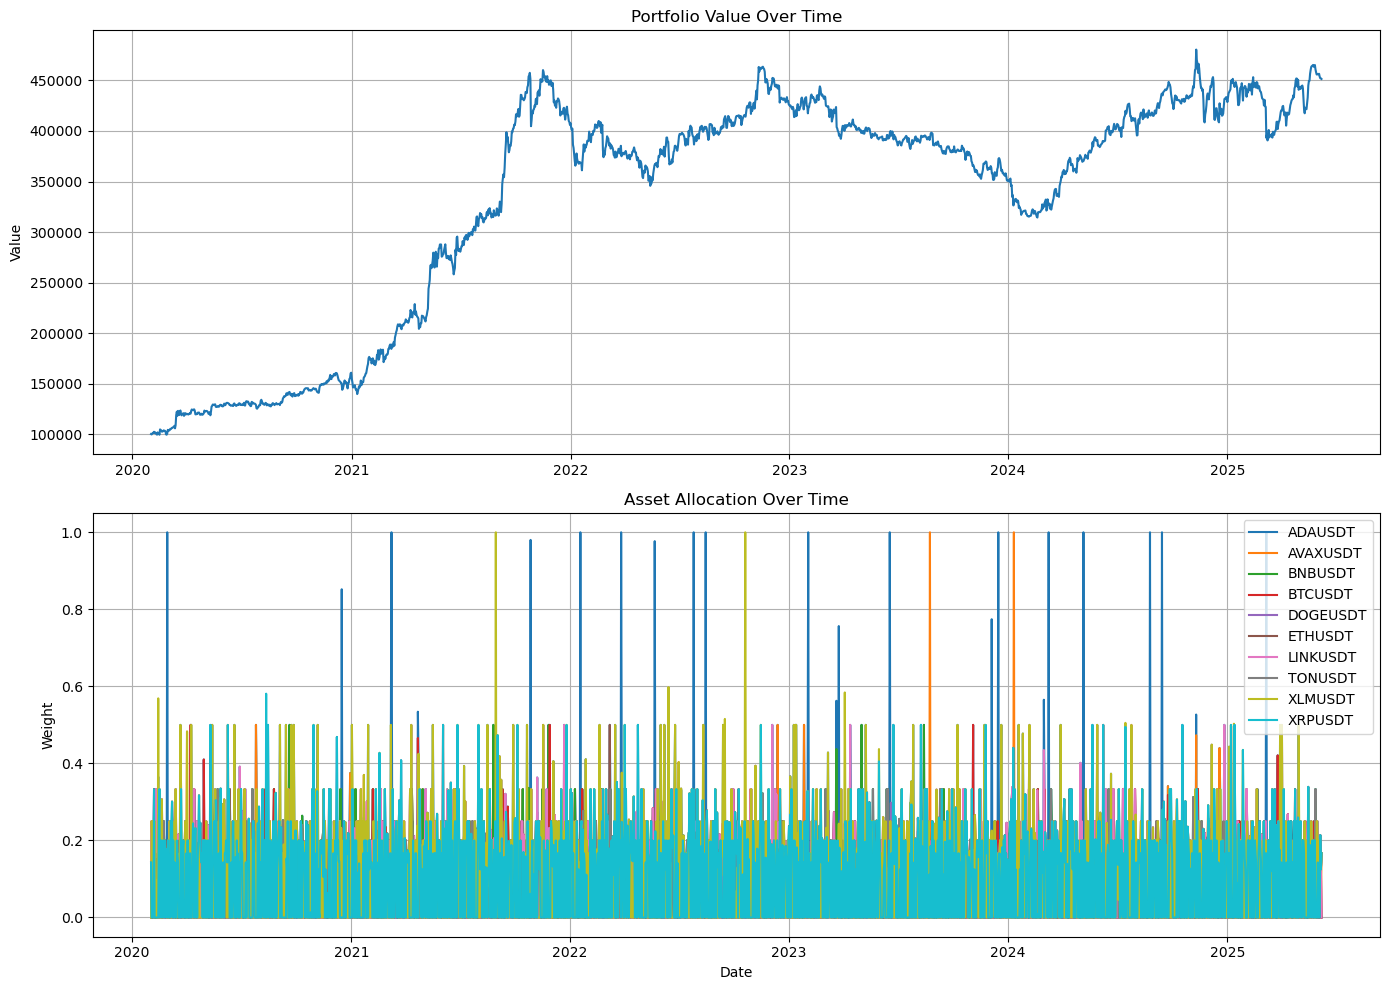


=== Performance Metrics ===
Total Return: 3.5153
Mean Return: 0.0009
Volatility: 0.0129
Sharpe Ratio: 0.0664
Max Drawdown: -0.3220
Avg Turnover: 1.2270
Total Transaction Costs: 800884.5484


In [107]:
# backtester = CryptoRLBacktester(df_daily_pct_trade)
# backtester.train_model(timesteps=100_000)  # Try 100k+ for daily data
# results = backtester.run_backtest()
# backtester.plot_results()
# metrics = backtester.get_metrics()
# print("\n=== Performance Metrics ===")
# for k, v in metrics.items():
#     print(f"{k}: {v:.4f}")


In [59]:
# import gym
# from gym import spaces
# from stable_baselines3 import PPO
# from stable_baselines3.common.vec_env import DummyVecEnv

# class FeaturePortfolioEnv(gym.Env):
#     def __init__(self, features_df, returns_df, lookback=15, cost_penalty=0.002):
#         super().__init__()
#         self.features_df = features_df
#         self.returns_df = returns_df
#         self.lookback = lookback
#         self.n_assets = returns_df.shape[1]
#         self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
#         # obs: [lookback, features] flattened
#         self.observation_space = spaces.Box(
#             low=-10, high=10, shape=(lookback * features_df.shape[1],), dtype=np.float32)
#         self.reset()

#     def reset(self):
#         self.current_step = self.lookback
#         self.done = False
#         self.current_weights = np.ones(self.n_assets) / self.n_assets
#         self.returns_history = []
#         return self._get_obs()

#     def _get_obs(self):
#         obs = self.features_df.iloc[self.current_step - self.lookback:self.current_step].values
#         obs = (obs - np.nanmean(obs, axis=0)) / (np.nanstd(obs, axis=0) + 1e-8)
#         return obs.flatten()

#     def step(self, action):
#         weights = np.clip(action, 0, 1)
#         weights = weights / np.sum(weights) if np.sum(weights) > 0 else np.ones_like(weights) / len(weights)

#         # Next day's return
#         ret = self.returns_df.iloc[self.current_step].values
#         turnover = np.sum(np.abs(weights - self.current_weights))
#         portfolio_ret = np.dot(weights, ret)
#         self.returns_history.append(portfolio_ret)
#         self.current_weights = weights

#         reward = portfolio_ret - self.cost_penalty * turnover  # Or try Sharpe-based: reward = mean(last N returns)/std

#         self.current_step += 1
#         self.done = self.current_step >= len(self.returns_df)
#         obs = self._get_obs() if not self.done else np.zeros(self.observation_space.shape)
#         info = {'weights': weights}
#         return obs, reward, self.done, info


In [96]:
# import pandas as pd
# import numpy as np

# # 1. Select which features to use
# selected_features = [
#     "momentum3", "entropy", "vol_of_vol", "ofi_z", "vol_pct", "is_NR4",
#     "price_zscore", "trend_up", "trend_down"
# ]

# # 2. For each ticker, build daily average of features (or use last value each day)
# feature_panels = {}
# for ticker, df in all_coin_data.items():
#     df = df.copy()
#     df["date"] = pd.to_datetime(df.index).date
#     daily_feats = df.groupby("date")[selected_features].mean()  # Or use .last()
#     # Prefix columns for each asset
#     daily_feats.columns = [f"{ticker}_{c}" for c in daily_feats.columns]
#     feature_panels[ticker] = daily_feats

# # 3. Concatenate all asset features by date
# df_features = pd.concat(feature_panels.values(), axis=1).sort_index()
# # Remove any rows with all NaN (bad days)
# df_features = df_features.dropna(how="all")
# # Align daily returns to feature DataFrame index
# df_returns = pd.DataFrame({t: v for t, v in coin_daily_pct.items()})
# df_returns = df_returns.loc[df_features.index].fillna(0.0)


In [98]:
# import gym
# from gym import spaces
# from stable_baselines3 import PPO
# from stable_baselines3.common.vec_env import DummyVecEnv

# class FeaturePortfolioEnv(gym.Env):
#     def __init__(self, features_df, returns_df, lookback=15, cost_penalty=0.002):
#         super().__init__()
#         self.features_df = features_df
#         self.returns_df = returns_df
#         self.lookback = lookback
#         self.n_assets = returns_df.shape[1]
#         self.cost_penalty = cost_penalty        # <-- add this line!
#         self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
#         self.observation_space = spaces.Box(
#             low=-10, high=10, shape=(lookback * features_df.shape[1],), dtype=np.float32)
#         self.reset()

#     def reset(self):
#         self.current_step = self.lookback
#         self.done = False
#         self.current_weights = np.ones(self.n_assets) / self.n_assets
#         self.returns_history = []
#         return self._get_obs()

#     def _get_obs(self):
#         obs = self.features_df.iloc[self.current_step - self.lookback:self.current_step].values
#         obs = (obs - np.nanmean(obs, axis=0)) / (np.nanstd(obs, axis=0) + 1e-8)
#         return obs.flatten()

#     def step(self, action):
#         weights = np.clip(action, 0, 1)
#         weights = weights / np.sum(weights) if np.sum(weights) > 0 else np.ones_like(weights) / len(weights)

#         # Next day's return
#         ret = self.returns_df.iloc[self.current_step].values
#         turnover = np.sum(np.abs(weights - self.current_weights))
#         portfolio_ret = np.dot(weights, ret)
#         self.returns_history.append(portfolio_ret)
#         self.current_weights = weights

#         reward = portfolio_ret - self.cost_penalty * turnover  # Or try Sharpe-based: reward = mean(last N returns)/std

#         self.current_step += 1
#         self.done = self.current_step >= len(self.returns_df)
#         obs = self._get_obs() if not self.done else np.zeros(self.observation_space.shape)
#         info = {'weights': weights}
#         return obs, reward, self.done, info


In [100]:
# # Remove rows with any/all NaNs in either features or returns
# common_idx = df_features.index.intersection(df_returns.index)
# df_features = df_features.loc[common_idx].copy()
# df_returns = df_returns.loc[common_idx].copy()

# # Remove any days where any asset's features are NaN (for RL, it's safer to drop than fillna)
# df_features = df_features.dropna(how='any')
# df_returns = df_returns.loc[df_features.index]  # align returns to cleaned features

# # Also check returns:
# df_returns = df_returns.dropna(how='any')
# df_features = df_features.loc[df_returns.index]

# print("Features shape:", df_features.shape)
# print("Returns shape:", df_returns.shape)
# print("Any features nan?", df_features.isnull().any().any())
# print("Any returns nan?", df_returns.isnull().any().any())


Features shape: (508, 72)
Returns shape: (508, 10)
Any features nan? False
Any returns nan? False


In [ ]:
# lookback = 15
# env = DummyVecEnv([lambda: FeaturePortfolioEnv(df_features, df_returns, lookback=lookback)])
# model = PPO(
#     "MlpPolicy", env, verbose=1, learning_rate=3e-4,
#     n_steps=128, batch_size=32, ent_coef=0.01
# )
# model.learn(total_timesteps=30000)  # Increase for longer training
# # ===============================================================
# # RL evaluation helper
# # ===============================================================
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# def evaluate_rl_portfolio(model, vec_env, price_df,  # price_df index must match env’s step order
#                           start_cash=1_000_000,
#                           tc_rate=0.0008,           # transaction fee (e.g. 8 bp)
#                           plot_name_suffix="OOS"):
#     """
#     model      : trained SB3 model (PPO/SAC/etc.)
#     vec_env    : DummyVecEnv or raw env in *testing* mode
#     price_df   : DataFrame of asset % returns (rows=steps, cols=assets) in the same
#                  chronological order as env.step() iterates
#     start_cash : starting portfolio value
#     tc_rate    : proportional fee on |Δw|
#     """

#     obs, _ = vec_env.reset()
#     done   = False
#     cash   = start_cash
#     prev_w = np.zeros(price_df.shape[1])           # assume flat at t=0

#     pv_curve   = [cash]
#     weight_mat = []

#     step_idx = 0
#     while not done:
#         action, _ = model.predict(obs, deterministic=True)
#         obs, reward, done, infos = vec_env.step(action)
#         w = np.clip(action[0], 0, 1)
#         w = w / w.sum() if w.sum() > 0 else np.ones_like(w) / len(w)

#         # ---- apply realised return ----
#         ret_vec  = price_df.iloc[step_idx].values
#         turn     = np.abs(w - prev_w).sum()
#         cash    *= (1 + np.dot(w, ret_vec) - tc_rate * turn)

#         # ---- store ----
#         pv_curve.append(cash)
#         weight_mat.append(w)
#         prev_w   = w.copy()
#         step_idx += 1

#     # -------------- plots -----------------
#     pv_curve = pd.Series(pv_curve, index=price_df.index[:len(pv_curve)])
#     weight_df = pd.DataFrame(weight_mat, index=price_df.index[:len(weight_mat)],
#                              columns=price_df.columns)

#     fig, ax = plt.subplots(2, 1, figsize=(14,10))

#     ax[0].plot(pv_curve)
#     ax[0].set_title(f"Portfolio Value ({plot_name_suffix})")
#     ax[0].set_ylabel("Equity")
#     ax[0].grid(True)

#     for col in weight_df:
#         ax[1].plot(weight_df[col], label=col)
#     ax[1].set_title("Asset Weights")
#     ax[1].set_xlabel("Step")
#     ax[1].set_ylabel("Weight")
#     ax[1].legend()
#     ax[1].grid(True)
#     plt.tight_layout()
#     plt.show()

#     # -------------- performance matrix --------------
#     returns = pv_curve.pct_change().fillna(0)
#     total_ret = pv_curve.iloc[-1] / pv_curve.iloc[0] - 1
#     mean_r, vol_r = returns.mean(), returns.std()
#     sharpe  = mean_r / (vol_r + 1e-8)
#     dd_curve = pv_curve.cummax()
#     max_dd  = ((pv_curve - dd_curve) / dd_curve).min()
#     avg_turn= np.abs(weight_df.diff()).dropna().sum(axis=1).mean()

#     perf = {
#         "Total Return"      : f"{total_ret:8.2%}",
#         "Mean Return"       : f"{mean_r:8.4%}",
#         "Volatility"        : f"{vol_r:8.4%}",
#         "Sharpe Ratio"      : f"{sharpe:6.2f}",
#         "Max Draw-down"     : f"{max_dd:8.2%}",
#         "Avg Turnover"      : f"{avg_turn:8.4f}",
#     }
#     print("\n=== Performance Metrics ===")
#     for k,v in perf.items():
#         print(f"{k:<18}: {v}")

#     return pv_curve, weight_df, perf



In [115]:
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from gym import Env, spaces
from sklearn.preprocessing import StandardScaler
from stable_baselines3.common.callbacks import BaseCallback
from tqdm import tqdm
import os

# ==== 1. Define run_single_coin_backtest (same as before, or use your fast version) ====
def run_single_coin_backtest(
    csv_path: str,
    ticker: str,
    notional_usd: float = 200_000,
    sma_fast: int = 30,
    sma_slow: int = 70,
    entropy_window: int = 20,
    entropy_percentile: float = 0.8,
    atr_mult: float = 2,
    max_bars: int = 3,
    ofi_z_thresh: float = 0.5,
    vol_surge_percentile: float = 0.6,
    opening_range_bars: int = 4,
    mean_rev_zscore_thresh: float = 1.5,
    active_hours: set = None,
    use_fixed_sl: bool = True
):
    df_1m = pd.read_csv(csv_path)
    time_col = 'open_time' if 'open_time' in df_1m.columns else 'timestamp'
    df_1m['open_time'] = pd.to_datetime(df_1m[time_col])
    df_1m = df_1m.set_index('open_time')
    df_1m = df_1m.loc["2024-01-01":"2025-06-30"]  # last ~1.5 years for speed

    coin_15m = df_1m.resample("15min").agg({
        "open": "first", "high": "max", "low": "min", "close": "last", "volume": "sum"
    }).dropna()
    coin_15m["hour"] = coin_15m.index.hour
    coin_15m["date"] = coin_15m.index.date

    def precompute_static_indicators(df):
        df = df.copy()
        df["tr"] = np.maximum(
            df["high"] - df["low"],
            np.maximum(
                (df["high"] - df["close"].shift(1)).abs(),
                (df["low"] - df["close"].shift(1)).abs()
            )
        )
        df["atr"] = df["tr"].rolling(14).mean()
        df["vol_of_vol"] = df["atr"].rolling(20).std()
        df["vol_of_vol_thresh"] = df["vol_of_vol"].rolling(100).quantile(0.7)
        ofi_raw = (df["close"] - df["open"]) + (df["close"] - df["low"]) - (df["high"] - df["close"])
        df["ofi"] = pd.Series(ofi_raw).rolling(5).mean()
        df["ofi_z_mean"] = df["ofi"].rolling(10).mean()
        df["ofi_z_std"] = df["ofi"].rolling(10).std()
        df["ofi_z"] = (df["ofi"] - df["ofi_z_mean"]) / df["ofi_z_std"]
        df["momentum3"] = df["close"].pct_change(3)
        df["vol_pct"] = df["volume"].rolling(20).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1])
        df["range"] = df["high"] - df["low"]
        df["is_NR4"] = df["range"].rolling(4).apply(lambda x: x[-1] == x.min(), raw=True)
        return df.dropna()
    coin_15m = precompute_static_indicators(coin_15m)
    coin_15m["sma_fast"] = coin_15m["close"].rolling(sma_fast).mean()
    coin_15m["sma_slow"] = coin_15m["close"].rolling(sma_slow).mean()
    coin_15m["sma_fast_slope"] = coin_15m["sma_fast"].diff(5)
    coin_15m["trend_up"] = coin_15m["sma_fast_slope"] > 0
    coin_15m["trend_down"] = coin_15m["sma_fast_slope"] < 0
    coin_15m["vwap"] = (coin_15m["close"] * coin_15m["volume"]).rolling(15).sum() / coin_15m["volume"].rolling(15).sum()
    def calculate_entropy(arr, window, bins=10):
        ent = [np.nan] * len(arr)
        for idx in range(window, len(arr)):
            slice_ = arr[idx - window: idx]
            hist, _ = np.histogram(slice_, bins=bins, density=True)
            probs = hist / hist.sum()
            probs = probs[probs > 0]
            h = -np.sum(probs * np.log(probs))
            ent[idx] = h / np.log(bins)
        return np.array(ent)
    coin_15m["entropy_raw"] = calculate_entropy(coin_15m["close"].values, entropy_window, bins=10)
    coin_15m["entropy"] = pd.Series(coin_15m["entropy_raw"]).rolling(5).mean()
    coin_15m["entropy_thresh"] = coin_15m["entropy"].rolling(100).quantile(entropy_percentile)
    coin_15m["is_entropy_ok"] = coin_15m["entropy"] < coin_15m["entropy_thresh"]
    def opening_range(group):
        high = group["high"].head(opening_range_bars).max()
        low = group["low"].head(opening_range_bars).min()
        return pd.Series({"opening_range_high": high, "opening_range_low": low})
    orb_ranges = coin_15m.groupby("date", group_keys=False).apply(opening_range, include_groups=False)
    coin_15m = coin_15m.merge(orb_ranges, left_on="date", right_index=True)
    coin_15m["orb_long"] = coin_15m["close"] > coin_15m["opening_range_high"]
    coin_15m["orb_short"] = coin_15m["close"] < coin_15m["opening_range_low"]
    coin_15m["sma_short"] = coin_15m["close"].rolling(10).mean()
    coin_15m["price_std"] = coin_15m["close"].rolling(10).std()
    coin_15m["price_zscore"] = (coin_15m["close"] - coin_15m["sma_short"]) / coin_15m["price_std"]
    coin_15m["mean_rev_long"] = coin_15m["price_zscore"] < -mean_rev_zscore_thresh
    coin_15m["mean_rev_short"] = coin_15m["price_zscore"] > mean_rev_zscore_thresh
    coin_15m["is_vol_of_vol_ok"] = coin_15m["vol_of_vol"] < coin_15m["vol_of_vol_thresh"]
    coin_15m["is_ofi_moderate"] = coin_15m["ofi_z"].abs() > ofi_z_thresh
    coin_15m["is_momentum_up"] = coin_15m["momentum3"] > 0
    coin_15m["is_momentum_down"] = coin_15m["momentum3"] < 0
    coin_15m["is_vol_surge"] = coin_15m["vol_pct"] > vol_surge_percentile
    coin_15m["is_NR4"] = coin_15m["is_NR4"].fillna(False)
    coin_15m = coin_15m.dropna()
    coin_15m["signal"] = 0
    active_hours = set(range(24)) if active_hours is None else active_hours
    mask_long = (
        coin_15m["hour"].isin(active_hours)
        & (
            (
                coin_15m["orb_long"]
                & coin_15m["is_entropy_ok"]
                & coin_15m["is_NR4"].shift(1).fillna(False)
                & coin_15m["is_vol_of_vol_ok"]
                & coin_15m["is_ofi_moderate"]
                & coin_15m["is_momentum_up"]
                & coin_15m["is_vol_surge"]
                & coin_15m["trend_up"]
                & (coin_15m["close"] > coin_15m["vwap"])
                & (coin_15m["sma_fast"] > coin_15m["sma_slow"])
            )
            | (
                coin_15m["mean_rev_long"]
                & coin_15m["is_entropy_ok"]
                & coin_15m["is_vol_of_vol_ok"]
                & coin_15m["is_ofi_moderate"]
                & (coin_15m["close"] < coin_15m["vwap"])
            )
        )
    )
    mask_short = (
        coin_15m["hour"].isin(active_hours)
        & (
            (
                coin_15m["orb_short"]
                & coin_15m["is_entropy_ok"]
                & coin_15m["is_NR4"].shift(1).fillna(False)
                & coin_15m["is_vol_of_vol_ok"]
                & coin_15m["is_ofi_moderate"]
                & coin_15m["is_momentum_down"]
                & coin_15m["is_vol_surge"]
                & coin_15m["trend_down"]
                & (coin_15m["close"] < coin_15m["vwap"])
                & (coin_15m["sma_fast"] < coin_15m["sma_slow"])
            )
            | (
                coin_15m["mean_rev_short"]
                & coin_15m["is_entropy_ok"]
                & coin_15m["is_vol_of_vol_ok"]
                & coin_15m["is_ofi_moderate"]
                & (coin_15m["close"] > coin_15m["vwap"])
            )
        )
    )
    coin_15m.loc[mask_long, "signal"] = 1
    coin_15m.loc[mask_short, "signal"] = -1

    # For RL, just return features and returns. (Skip trade_log for now)
    coin_15m["strategy_returns_pct"] = coin_15m["signal"].shift().fillna(0) * coin_15m["close"].pct_change().fillna(0)
    coin_15m["market_returns"] = coin_15m["close"].pct_change().fillna(0)
    return coin_15m, pd.DataFrame(), pd.Series(), pd.Series()

# ==== 2. Define RL Environment ====
class FeaturePortfolioEnv(Env):
    def __init__(self, df_features, df_returns, lookback=15):
        super().__init__()
        self.df_features = df_features
        self.df_returns = df_returns
        self.lookback = lookback
        self.n_tickers = df_returns.shape[1]
        self.action_space = spaces.Box(low=-0.3, high=0.3, shape=(self.n_tickers,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(len(df_features.columns) * lookback,), dtype=np.float32)
        self.current_step = lookback
        self.max_steps = len(df_features) - 1

    def reset(self):
        self.current_step = self.lookback
        return self._get_observation()

    def step(self, action):
        weights = action / np.sum(np.abs(action)) if np.sum(np.abs(action)) != 0 else np.zeros_like(action)
        returns = self.df_returns.iloc[self.current_step].values
        recent_returns = self.df_returns.iloc[self.current_step - self.lookback:self.current_step].dot(weights)
        mean_return = np.mean(recent_returns) * 252
        std_return = np.std(recent_returns) * np.sqrt(252)
        sharpe = mean_return / std_return if std_return != 0 else 0
        reward = sharpe - 0.1 * std_return
        self.current_step += 1
        done = self.current_step >= self.max_steps
        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        return self.df_features.iloc[self.current_step - self.lookback:self.current_step].values.flatten()

class LinearSchedule(BaseCallback):
    def __init__(self, initial_lr, final_lr, total_timesteps):
        super().__init__()
        self.initial_lr = initial_lr
        self.final_lr = final_lr
        self.total_timesteps = total_timesteps
    def _on_step(self):
        fraction = min(self.num_timesteps / self.total_timesteps, 1.0)
        lr = self.initial_lr + fraction * (self.final_lr - self.initial_lr)
        self.model.policy.optimizer.param_groups[0]['lr'] = lr
        return True

# ==== 3. Main: Run backtests (serial for notebook) ====
paths = {
    "ETHUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\ETHUSDT_1m_7 years from Binance.csv",
    "BTCUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\BTCUSDT_1m_7 years from Binance.csv",
    "BNBUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\BNBUSDT_1m_7 years from Binance.csv",
    "XRPUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\XRPUSDT_1m_7 years from Binance.csv",
    "DOGEUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\DOGEUSDT_1m_6 years from Binance.csv",
    "ADAUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\ADAUSDT_1min_data.csv",
    "XLMUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\XLMUSDT_1min_data.csv",
    "LINKUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\LINKUSDT_1min_data.csv",
    "AVAXUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\AVAXUSDT_1min_data.csv",
    "TONUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\TONUSDT_1min_data.csv",
}
all_coin_data = {}
for ticker, path in tqdm(paths.items(), desc="Coins Processed"):
    coin_15m, _, _, _ = run_single_coin_backtest(csv_path=path, ticker=ticker)
    all_coin_data[ticker] = coin_15m

# ==== 4. Prepare features and returns ====
feature_cols = ['sma_fast', 'sma_slow', 'vwap', 'momentum3']
all_feat = []
all_ret = []
for ticker, df in all_coin_data.items():
    feats = [col for col in feature_cols if col in df.columns]
    renamed_feats = {col: f"{ticker}_{col}" for col in feats}
    features = df[feats].rename(columns=renamed_feats)
    features_daily = features.resample('D').last().copy()
    returns_daily = df['strategy_returns_pct'].resample('D').apply(lambda x: (1 + x).prod() - 1).rename(ticker)
    all_feat.append(features_daily)
    all_ret.append(returns_daily)
df_features = pd.concat(all_feat, axis=1).dropna()
df_returns = pd.concat(all_ret, axis=1).reindex(df_features.index).fillna(0)
scaler = StandardScaler()
df_features_scaled = pd.DataFrame(scaler.fit_transform(df_features), index=df_features.index, columns=df_features.columns)

# ==== 5. RL Training ====
lookback = 15
env = DummyVecEnv([lambda: FeaturePortfolioEnv(df_features_scaled, df_returns, lookback=lookback)])
policy_kwargs = dict(net_arch=[64, 64])
model = PPO(
    "MlpPolicy",
    env,
    learning_rate=3e-4,
    n_steps=128,
    batch_size=32,
    ent_coef=0.01,
    verbose=1,
    policy_kwargs=policy_kwargs
)
model.learn(total_timesteps=50000, callback=LinearSchedule(3e-4, 1e-5, 50000))

# ==== 6. RL Evaluation: Out-of-sample with progress bar ====
holdout_size = int(0.2 * len(df_features_scaled))
holdout_features = df_features_scaled.iloc[-holdout_size:]
holdout_returns = df_returns.iloc[-holdout_size:]
train_features = df_features_scaled.iloc[:-holdout_size]  # <-- NEW
train_returns  = df_returns.iloc[:-holdout_size]          # <-- NEW
obs = holdout_features.iloc[0:lookback].values.flatten()
weights = []
for i in tqdm(range(lookback, len(holdout_features)), desc="Evaluating RL Out-of-sample"):
    action, _ = model.predict(obs, deterministic=True)
    weights.append(action)
    obs = holdout_features.iloc[i-lookback+1:i+1].values.flatten()
weights = np.array(weights)
# Each row is weights for each day, so multiply elementwise and sum along axis=1
portfolio_returns = np.sum(holdout_returns.iloc[lookback:].values * weights, axis=1)
mean_return = np.mean(portfolio_returns) * 252
std_return = np.std(portfolio_returns) * np.sqrt(252)
sharpe = mean_return / std_return if std_return != 0 else np.nan
print(f"\nOut-of-sample Sharpe Ratio: {sharpe:.2f}")

model.save("ppo_portfolio_model")

Coins Processed: 100%|█████████████████████████████████████████████████████████████████| 10/10 [07:16<00:00, 43.60s/it]
C:\Users\sandy\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
----------------------------
| time/              |     |
|    fps             | 324 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 128 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 181         |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 256         |
| train/                  |             |
|    approx_kl            | 0.015161118 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -14.2       |
|    explained_variance   | -0.0211     |
|    learning_rate        | 0.0003      |
|    loss                 | 231         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0612     |
|    std                  | 1           |
|    value_loss           | 395         |
------------------------

Evaluating RL Out-of-sample: 100%|████████████████████████████████████████████████████| 42/42 [00:00<00:00, 630.24it/s]


Out-of-sample Sharpe Ratio: 5.70


Testing: 100%|████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 592.44it/s]


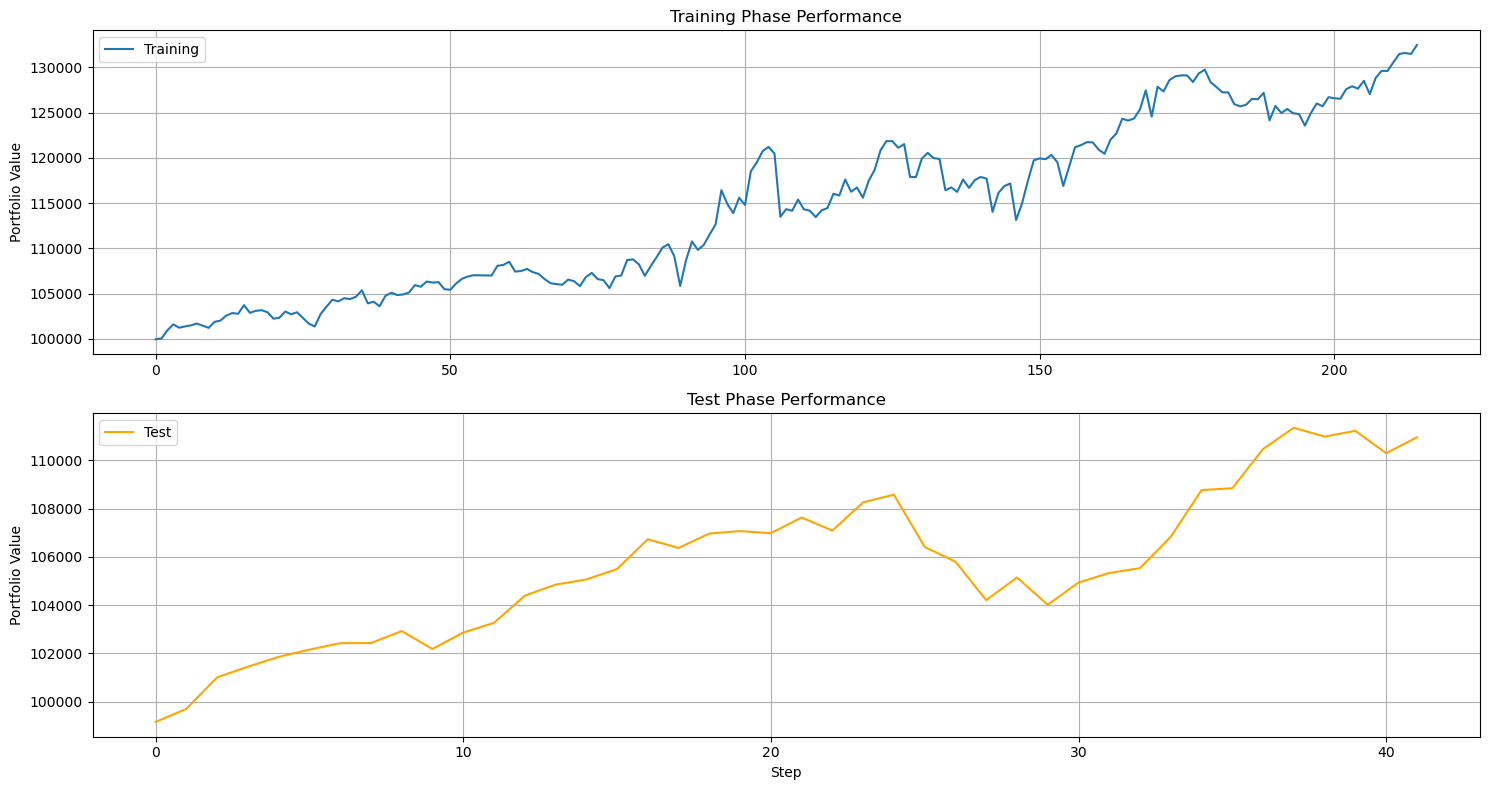


=== Performance Metrics Comparison ===
          total_return  annualized_return  annualized_volatility  \
Training        0.3246             0.3903                 0.1703   
Test            0.1095             0.8653                 0.1239   

          sharpe_ratio  max_drawdown  sortino_ratio  win_rate  calmar_ratio  \
Training        2.2920       -0.0716         2.6703    0.5628        5.4525   
Test            6.9863       -0.0420        10.2701    0.7381       20.6245   

          avg_turnover  total_tcost  
Training        0.6904   14844.2723  
Test               NaN          NaN  


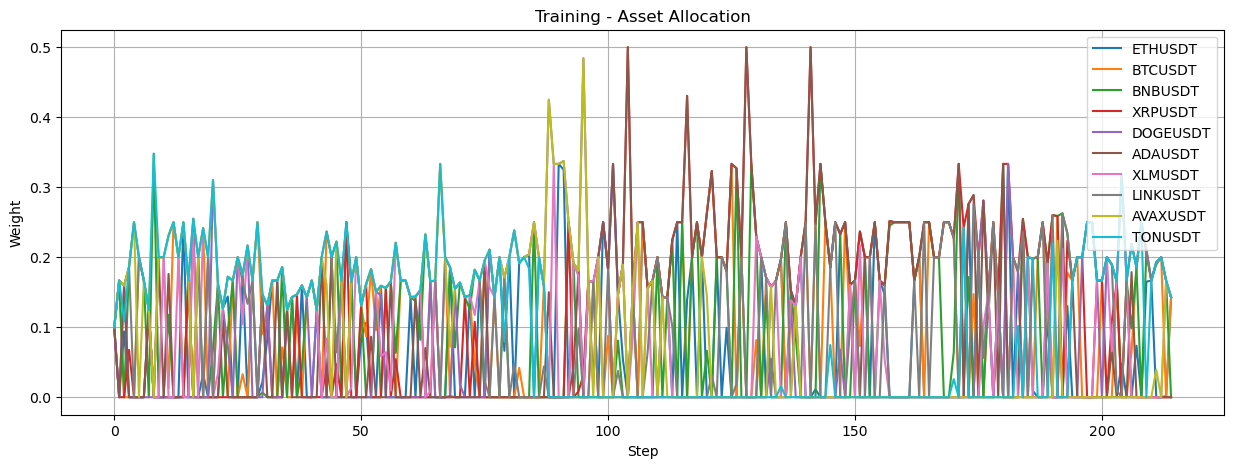

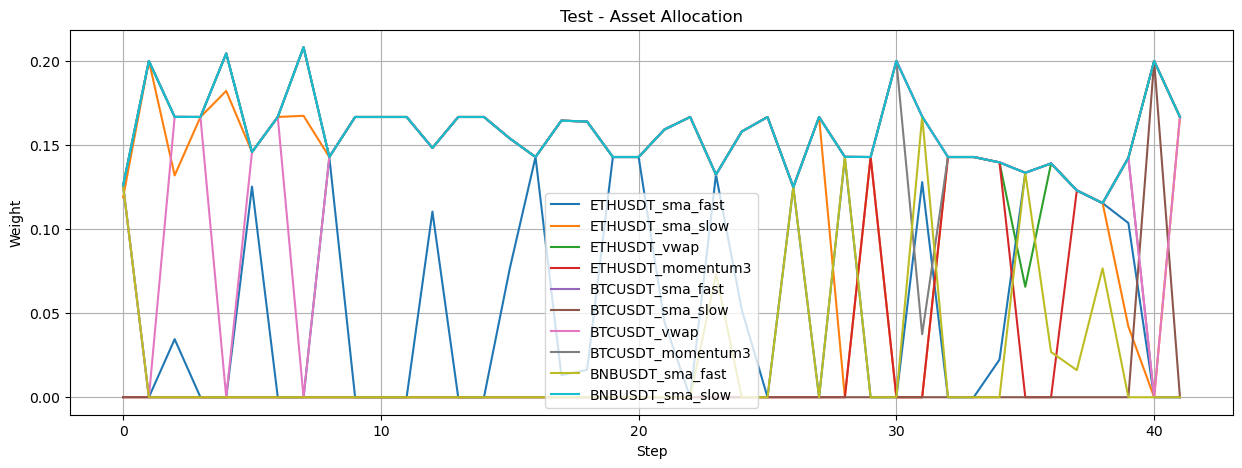

In [129]:
# Initialize tracker
perf_tracker = PerformanceTracker()

# ===== TRAINING PHASE =====
# Initialize with equal weights
current_weights = np.ones(train_returns.shape[1]) / train_returns.shape[1]

for i in tqdm(range(len(train_features) - lookback), desc="Training"):
    # Get current observation
    obs = train_features.iloc[i:i+lookback].values.flatten()
    
    # Get action from model
    action, _ = model.predict(obs, deterministic=False)
    
    # Normalize weights
    new_weights = np.clip(action, 0, 1)
    new_weights = new_weights / np.sum(new_weights)
    
    # Get returns for next period
    returns = train_returns.iloc[i+lookback].values
    
    # Record training step
    perf_tracker.record_train_step(returns, current_weights, new_weights, i)
    
    # Update weights
    current_weights = new_weights

# Finalize training metrics
train_metrics = perf_tracker.finalize_train_metrics()

# ===== TESTING PHASE ===== 
# Re-initialize with equal weights
current_weights = np.ones(holdout_returns.shape[1]) / holdout_returns.shape[1]

for i in tqdm(range(len(holdout_features) - lookback), desc="Testing"):
    # Get current observation
    obs = holdout_features.iloc[i:i+lookback].values.flatten()
    
    # Get action from model
    action, _ = model.predict(obs, deterministic=True)
    
    # Normalize weights
    new_weights = np.clip(action, 0, 1)
    new_weights = new_weights / np.sum(new_weights)
    
    # Get returns for next period
    returns = holdout_returns.iloc[i+lookback].values
    
    # Record test step
    perf_tracker.record_test_step(returns, new_weights, i)
    
    # Update weights (for consistency, though not used in test recording)
    current_weights = new_weights

# Finalize test metrics
test_metrics = perf_tracker.finalize_test_metrics()

# ===== VISUALIZATION =====
perf_tracker.plot_performance()
metrics_comparison = perf_tracker.print_metrics_comparison()

# Asset allocation analysis
def analyze_weights(history, asset_names, title):
    weights = np.array([x['weights'] for x in history])
    plt.figure(figsize=(15, 5))
    for i in range(weights.shape[1]):
        plt.plot(weights[:, i], label=asset_names[i])
    plt.title(f'{title} - Asset Allocation')
    plt.xlabel('Step')
    plt.ylabel('Weight')
    plt.legend()
    plt.grid(True)
    plt.show()

analyze_weights(perf_tracker.train_history, train_returns.columns, 'Training')
analyze_weights(perf_tracker.test_history, holdout_features.columns, 'Test')

In [139]:
# import warnings

In [141]:
# def safe_statistics_calculation(data_list, key):
#     """Helper function to safely calculate statistics with empty data handling"""
#     if not data_list:
#         return {
#             'mean': np.nan,
#             'median': np.nan,
#             'std_dev': np.nan,
#             'skewness': np.nan,
#             'kurtosis': np.nan,
#             'min': np.nan,
#             'max': np.nan,
#             'positive_ratio': np.nan
#         }
    
#     values = [x[key] for x in data_list if key in x]
    
#     if not values:
#         return {
#             'mean': np.nan,
#             'median': np.nan,
#             'std_dev': np.nan,
#             'skewness': np.nan,
#             'kurtosis': np.nan,
#             'min': np.nan,
#             'max': np.nan,
#             'positive_ratio': np.nan
#         }
    
#     return {
#         'mean': np.nanmean(values),
#         'median': np.nanmedian(values),
#         'std_dev': np.nanstd(values),
#         'skewness': pd.Series(values).skew(),
#         'kurtosis': pd.Series(values).kurt(),
#         'min': np.nanmin(values) if len(values) > 0 else np.nan,
#         'max': np.nanmax(values) if len(values) > 0 else np.nan,
#         'positive_ratio': np.nanmean([x > 0 for x in values])
#     }

# def generate_statistical_summary(perf_tracker, train_returns, holdout_returns):
#     """Generate robust statistical summary with empty data handling"""
    
#     # 1. Basic Performance Metrics
#     summary = {
#         'training_metrics': getattr(perf_tracker, 'train_metrics', {}),
#         'test_metrics': getattr(perf_tracker, 'test_metrics', {}),
        
#         # 2. Return Statistics
#         'return_stats': {
#             'training': safe_statistics_calculation(
#                 getattr(perf_tracker, 'train_history', []), 
#                 'net_return'
#             ),
#             'test': safe_statistics_calculation(
#                 getattr(perf_tracker, 'test_history', []), 
#                 'portfolio_return'
#             )
#         },
        
#         # 3. Portfolio Turnover Analysis
#         'turnover_stats': {
#             'avg_daily_turnover': perf_tracker.train_metrics.get('avg_turnover', np.nan),
#             'total_transaction_costs': perf_tracker.train_metrics.get('total_tcost', np.nan),
#             'turnover_correlation_with_returns': safe_correlation(
#                 [x.get('turnover', np.nan) for x in getattr(perf_tracker, 'train_history', [])],
#                 [x.get('net_return', np.nan) for x in getattr(perf_tracker, 'train_history', [])]
#             )
#         },
        
#         # 4. Asset Allocation Statistics
#         'allocation_stats': {
#             'avg_weight_per_asset_train': safe_asset_allocation(
#                 getattr(perf_tracker, 'train_history', []), 
#                 train_returns.columns if train_returns is not None else []
#             ),
#             'avg_weight_per_asset_test': safe_asset_allocation(
#                 getattr(perf_tracker, 'test_history', []), 
#                 holdout_returns.columns if holdout_returns is not None else []
#             ),
#             'allocation_concentration': safe_concentration_metrics(
#                 getattr(perf_tracker, 'train_history', []),
#                 getattr(perf_tracker, 'test_history', [])
#             )
#         },
        
#         # 5. Benchmark Comparison
#         'benchmark_comparison': safe_benchmark_comparison(
#             perf_tracker,
#             train_returns,
#             holdout_returns
#         ),
        
#         # 6. Risk Analysis
#         'risk_analysis': safe_risk_analysis(
#             getattr(perf_tracker, 'train_history', []),
#             getattr(perf_tracker, 'test_history', [])
#         )
#     }
    
#     return summary

# def safe_correlation(x, y):
#     """Calculate correlation with empty data handling"""
#     if len(x) == 0 or len(y) == 0:
#         return np.nan
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         return np.corrcoef(x, y)[0, 1]

# def safe_asset_allocation(history, asset_names):
#     """Calculate asset allocation stats with empty data handling"""
#     if not history or not asset_names:
#         return {asset: np.nan for asset in asset_names}
    
#     return {
#         asset: np.nanmean([x.get('weights', [np.nan]*len(asset_names))[i] 
#                          for x in history if 'weights' in x])
#         for i, asset in enumerate(asset_names)
#     }

# def safe_concentration_metrics(train_history, test_history):
#     """Calculate concentration metrics with empty data handling"""
#     def calc_concentration(history):
#         if not history:
#             return {'herfindahl_index': np.nan, 'max_weight_avg': np.nan}
        
#         weights = [x.get('weights', []) for x in history]
#         valid_weights = [w for w in weights if len(w) > 0]
        
#         if not valid_weights:
#             return {'herfindahl_index': np.nan, 'max_weight_avg': np.nan}
        
#         return {
#             'herfindahl_index': np.nanmean([np.sum(np.square(w)) for w in valid_weights]),
#             'max_weight_avg': np.nanmean([np.max(w) for w in valid_weights])
#         }
    
#     return {
#         'train': calc_concentration(train_history),
#         'test': calc_concentration(test_history)
#     }

# def safe_benchmark_comparison(perf_tracker, train_returns, holdout_returns):
#     """Benchmark comparison with empty data handling"""
#     def calc_benchmark(returns, strategy_return):
#         if returns is None or len(returns) == 0:
#             return {
#                 'strategy_return': strategy_return,
#                 'equal_weight_return': np.nan,
#                 'outperformance': np.nan
#             }
        
#         equal_weight_returns = returns.mean(axis=1)
#         if len(equal_weight_returns) == 0:
#             equal_weight_total = np.nan
#         else:
#             equal_weight_total = (1 + equal_weight_returns).prod() - 1
        
#         return {
#             'strategy_return': strategy_return if not np.isnan(strategy_return) else np.nan,
#             'equal_weight_return': equal_weight_total,
#             'outperformance': (strategy_return - equal_weight_total 
#                              if not np.isnan(strategy_return) else np.nan)
#         }
    
#     return {
#         'train': calc_benchmark(
#             train_returns,
#             perf_tracker.train_metrics.get('total_return', np.nan)
#         ),
#         'test': calc_benchmark(
#             holdout_returns,
#             perf_tracker.test_metrics.get('total_return', np.nan)
#         )
#     }

# def safe_risk_analysis(train_history, test_history):
#     """Risk analysis with empty data handling"""
#     def calc_drawdown(history):
#         if not history:
#             return np.nan
        
#         portfolio_values = [x.get('portfolio_value', np.nan) for x in history]
#         if all(np.isnan(portfolio_values)):
#             return np.nan
        
#         peak = np.maximum.accumulate([np.nan_to_num(x, nan=-np.inf) for x in portfolio_values])
#         drawdowns = [(pv - p) / p if p != 0 else np.nan 
#                     for pv, p in zip(portfolio_values, peak)]
#         return np.nanargmin(drawdowns) if not all(np.isnan(drawdowns)) else np.nan
    
#     def calc_volatility_ratio(train_metrics, test_metrics):
#         train_vol = train_metrics.get('annualized_volatility', np.nan)
#         test_vol = test_metrics.get('annualized_volatility', np.nan)
#         return test_vol / train_vol if train_vol != 0 else np.nan
    
#     return {
#         'worst_drawdown_period_train': calc_drawdown(train_history),
#         'worst_drawdown_period_test': calc_drawdown(test_history),
#         'volatility_ratio': calc_volatility_ratio(
#             getattr(perf_tracker, 'train_metrics', {}),
#             getattr(perf_tracker, 'test_metrics', {})
#         )
#     }

# # Generate and print the summary with error handling
# try:
#     stats_summary = generate_statistical_summary(perf_tracker, train_returns, holdout_returns)
#     print_statistical_summary(stats_summary)
#     save_summary_to_csv(stats_summary)
# except Exception as e:
#     print(f"Error generating summary: {str(e)}")
#     stats_summary = {}

Error generating summary: The truth value of a Index is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().


In [135]:
# def generate_statistical_summary(perf_tracker, train_returns, holdout_returns):
#     """
#     Generate a comprehensive statistical summary of the RL portfolio strategy
    
#     Parameters:
#     perf_tracker: PerformanceTracker object containing training and test history
#     train_returns: DataFrame of training period returns
#     holdout_returns: DataFrame of test period returns
    
#     Returns:
#     dict: Dictionary containing all statistical summaries
#     """
    
#     # 1. Basic Performance Metrics
#     summary = {
#         'training_metrics': perf_tracker.train_metrics,
#         'test_metrics': perf_tracker.test_metrics,
        
#         # 2. Return Statistics
#         'return_stats': {
#             'training': {
#                 'mean': np.mean([x['net_return'] for x in perf_tracker.train_history]),
#                 'median': np.median([x['net_return'] for x in perf_tracker.train_history]),
#                 'std_dev': np.std([x['net_return'] for x in perf_tracker.train_history]),
#                 'skewness': pd.Series([x['net_return'] for x in perf_tracker.train_history]).skew(),
#                 'kurtosis': pd.Series([x['net_return'] for x in perf_tracker.train_history]).kurt(),
#                 'min': np.min([x['net_return'] for x in perf_tracker.train_history]),
#                 'max': np.max([x['net_return'] for x in perf_tracker.train_history]),
#                 'positive_ratio': np.mean([x['net_return'] > 0 for x in perf_tracker.train_history])
#             },
#             'test': {
#                 'mean': np.mean([x['portfolio_return'] for x in perf_tracker.test_history]),
#                 'median': np.median([x['portfolio_return'] for x in perf_tracker.test_history]),
#                 'std_dev': np.std([x['portfolio_return'] for x in perf_tracker.test_history]),
#                 'skewness': pd.Series([x['portfolio_return'] for x in perf_tracker.test_history]).skew(),
#                 'kurtosis': pd.Series([x['portfolio_return'] for x in perf_tracker.test_history]).kurt(),
#                 'min': np.min([x['portfolio_return'] for x in perf_tracker.test_history]),
#                 'max': np.max([x['portfolio_return'] for x in perf_tracker.test_history]),
#                 'positive_ratio': np.mean([x['portfolio_return'] > 0 for x in perf_tracker.test_history])
#             }
#         },
        
#         # 3. Portfolio Turnover Analysis
#         'turnover_stats': {
#             'avg_daily_turnover': perf_tracker.train_metrics.get('avg_turnover', 0),
#             'total_transaction_costs': perf_tracker.train_metrics.get('total_tcost', 0),
#             'turnover_correlation_with_returns': np.corrcoef(
#                 [x['turnover'] for x in perf_tracker.train_history],
#                 [x['net_return'] for x in perf_tracker.train_history]
#             )[0, 1]
#         },
        
#         # 4. Asset Allocation Statistics
#         'allocation_stats': {
#             'avg_weight_per_asset_train': {
#                 asset: np.mean([x['weights'][i] for x in perf_tracker.train_history])
#                 for i, asset in enumerate(train_returns.columns)
#             },
#             'avg_weight_per_asset_test': {
#                 asset: np.mean([x['weights'][i] for x in perf_tracker.test_history])
#                 for i, asset in enumerate(holdout_returns.columns)
#             },
#             'allocation_concentration': {
#                 'train': {
#                     'herfindahl_index': np.mean([
#                         np.sum(np.square(x['weights'])) for x in perf_tracker.train_history
#                     ]),
#                     'max_weight_avg': np.mean([
#                         np.max(x['weights']) for x in perf_tracker.train_history
#                     ])
#                 },
#                 'test': {
#                     'herfindahl_index': np.mean([
#                         np.sum(np.square(x['weights'])) for x in perf_tracker.test_history
#                     ]),
#                     'max_weight_avg': np.mean([
#                         np.max(x['weights']) for x in perf_tracker.test_history
#                     ])
#                 }
#             }
#         },
        
#         # 5. Benchmark Comparison
#         'benchmark_comparison': {
#             'train': {
#                 'strategy_return': perf_tracker.train_metrics['total_return'],
#                 'equal_weight_return': (1 + train_returns.mean(axis=1)).prod() - 1,
#                 'outperformance': perf_tracker.train_metrics['total_return'] - 
#                                  ((1 + train_returns.mean(axis=1)).prod() - 1)
#             },
#             'test': {
#                 'strategy_return': perf_tracker.test_metrics['total_return'],
#                 'equal_weight_return': (1 + holdout_returns.mean(axis=1)).prod() - 1,
#                 'outperformance': perf_tracker.test_metrics['total_return'] - 
#                                 ((1 + holdout_returns.mean(axis=1)).prod() - 1)
#             }
#         },
        
#         # 6. Risk Analysis
#         'risk_analysis': {
#             'worst_drawdown_period_train': np.argmin([
#                 (x['portfolio_value'] - np.maximum.accumulate(
#                     [y['portfolio_value'] for y in perf_tracker.train_history[:i+1]]
#                 )[-1]) / np.maximum.accumulate(
#                     [y['portfolio_value'] for y in perf_tracker.train_history[:i+1]]
#                 )[-1]
#                 for i, x in enumerate(perf_tracker.train_history)
#             ]),
#             'worst_drawdown_period_test': np.argmin([
#                 (x['portfolio_value'] - np.maximum.accumulate(
#                     [y['portfolio_value'] for y in perf_tracker.test_history[:i+1]]
#                 )[-1]) / np.maximum.accumulate(
#                     [y['portfolio_value'] for y in perf_tracker.test_history[:i+1]]
#                 )[-1]
#                 for i, x in enumerate(perf_tracker.test_history)
#             ]),
#             'volatility_ratio': (
#                 perf_tracker.test_metrics['annualized_volatility'] / 
#                 perf_tracker.train_metrics['annualized_volatility']
#             )
#         }
#     }
    
#     return summary

# def print_statistical_summary(summary):
#     """Print formatted statistical summary"""
    
#     # 1. Basic Performance
#     print("="*80)
#     print("PORTFOLIO STRATEGY STATISTICAL SUMMARY".center(80))
#     print("="*80)
    
#     print("\n1. BASIC PERFORMANCE METRICS")
#     print("-"*80)
#     print("{:<25} {:<25} {:<25}".format("Metric", "Training", "Test"))
#     print("-"*80)
#     for metric in summary['training_metrics']:
#         print("{:<25} {:<25.4f} {:<25.4f}".format(
#             metric,
#             summary['training_metrics'][metric],
#             summary['test_metrics'].get(metric, np.nan)
#         ))
    
#     # 2. Return Statistics
#     print("\n2. RETURN STATISTICS")
#     print("-"*80)
#     print("{:<25} {:<25} {:<25}".format("Statistic", "Training", "Test"))
#     print("-"*80)
#     for stat in summary['return_stats']['training']:
#         print("{:<25} {:<25.4f} {:<25.4f}".format(
#             stat,
#             summary['return_stats']['training'][stat],
#             summary['return_stats']['test'][stat]
#         ))
    
#     # 3. Turnover Analysis
#     print("\n3. TURNOVER ANALYSIS")
#     print("-"*80)
#     print("Average Daily Turnover: {:.4f}".format(summary['turnover_stats']['avg_daily_turnover']))
#     print("Total Transaction Costs: ${:,.2f}".format(summary['turnover_stats']['total_transaction_costs']))
#     print("Turnover-Return Correlation: {:.4f}".format(
#         summary['turnover_stats']['turnover_correlation_with_returns']
#     ))
    
#     # 4. Asset Allocation
#     print("\n4. ASSET ALLOCATION STATISTICS")
#     print("-"*80)
#     print("{:<15} {:<15} {:<15}".format("Asset", "Avg Weight (Train)", "Avg Weight (Test)"))
#     print("-"*80)
#     for asset in summary['allocation_stats']['avg_weight_per_asset_train']:
#         print("{:<15} {:<15.4f} {:<15.4f}".format(
#             asset,
#             summary['allocation_stats']['avg_weight_per_asset_train'][asset],
#             summary['allocation_stats']['avg_weight_per_asset_test'].get(asset, 0)
#         ))
    
#     print("\nAllocation Concentration:")
#     print("  Training Herfindahl Index: {:.4f}".format(
#         summary['allocation_stats']['allocation_concentration']['train']['herfindahl_index']
#     ))
#     print("  Test Herfindahl Index: {:.4f}".format(
#         summary['allocation_stats']['allocation_concentration']['test']['herfindahl_index']
#     ))
    
#     # 5. Benchmark Comparison
#     print("\n5. BENCHMARK COMPARISON")
#     print("-"*80)
#     print("{:<25} {:<25} {:<25}".format("Metric", "Training", "Test"))
#     print("-"*80)
#     print("{:<25} {:<25.4f} {:<25.4f}".format(
#         "Strategy Return",
#         summary['benchmark_comparison']['train']['strategy_return'],
#         summary['benchmark_comparison']['test']['strategy_return']
#     ))
#     print("{:<25} {:<25.4f} {:<25.4f}".format(
#         "Equal Weight Return",
#         summary['benchmark_comparison']['train']['equal_weight_return'],
#         summary['benchmark_comparison']['test']['equal_weight_return']
#     ))
#     print("{:<25} {:<25.4f} {:<25.4f}".format(
#         "Outperformance",
#         summary['benchmark_comparison']['train']['outperformance'],
#         summary['benchmark_comparison']['test']['outperformance']
#     ))
    
#     # 6. Risk Analysis
#     print("\n6. RISK ANALYSIS")
#     print("-"*80)
#     print("Worst Drawdown Period (Train): {}".format(
#         summary['risk_analysis']['worst_drawdown_period_train']
#     ))
#     print("Worst Drawdown Period (Test): {}".format(
#         summary['risk_analysis']['worst_drawdown_period_test']
#     ))
#     print("Volatility Ratio (Test/Train): {:.4f}".format(
#         summary['risk_analysis']['volatility_ratio']
#     ))
#     print("="*80)

# # Generate and print the summary
# stats_summary = generate_statistical_summary(perf_tracker, train_returns, holdout_returns)
# print_statistical_summary(stats_summary)

# # Optionally save to CSV
# def save_summary_to_csv(summary, filename="rl_portfolio_summary.csv"):
#     """Save summary statistics to CSV"""
    
#     # Flatten the nested dictionary
#     flat_data = []
#     for category in summary:
#         if isinstance(summary[category], dict):
#             for subcat in summary[category]:
#                 if isinstance(summary[category][subcat], dict):
#                     for key, value in summary[category][subcat].items():
#                         flat_data.append({
#                             'category': category,
#                             'subcategory': subcat,
#                             'metric': key,
#                             'training_value': value if not isinstance(value, dict) else np.nan,
#                             'test_value': np.nan
#                         })
#                 else:
#                     flat_data.append({
#                         'category': category,
#                         'subcategory': '',
#                         'metric': subcat,
#                         'training_value': summary[category][subcat] if category == 'training_metrics' else np.nan,
#                         'test_value': summary[category][subcat] if category == 'test_metrics' else np.nan
#                     })
    
#     df = pd.DataFrame(flat_data)
#     df.to_csv(filename, index=False)
#     print(f"\nSummary saved to {filename}")

# save_summary_to_csv(stats_summary)

Rule-based returns not found or not aligned. Skipping rule-based comparison.


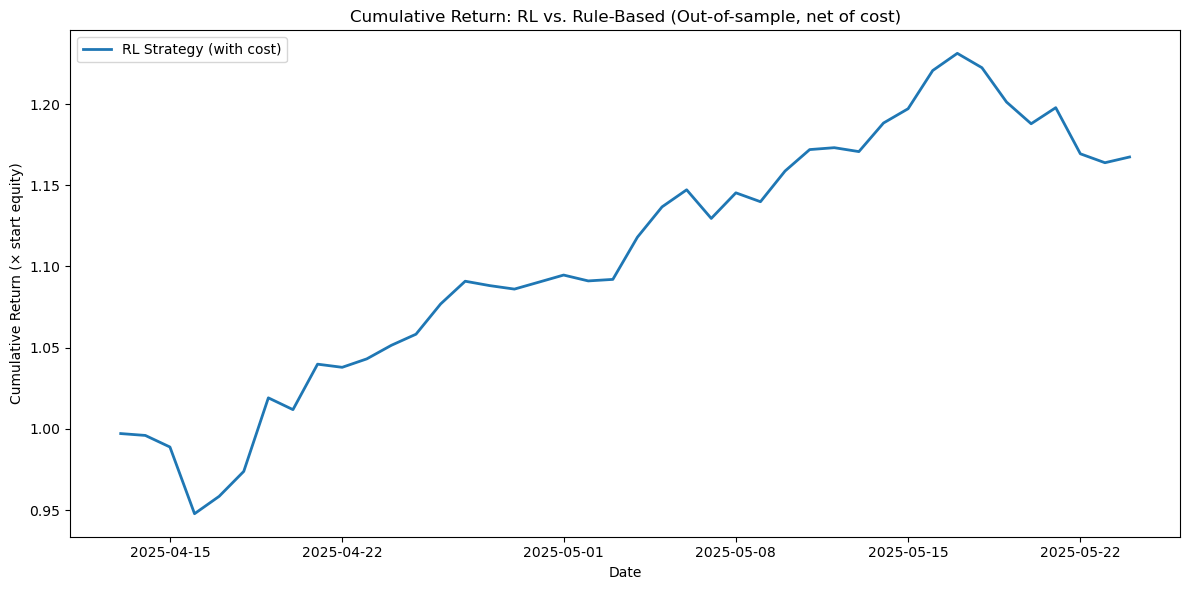


--- Out-of-Sample Performance (Net of Cost) ---
RL:     Sharpe 4.10 | CAGR 153.11% | Max DD -5.47%


In [13]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # ====== CONFIG ======
# transaction_fee = 0.0008   # 0.08% realistic for Binance spot/futures
# # You should set lookback to your actual value used in RL; adjust if needed:
# lookback = 5

# # ----- RL OUTPUTS (assume these are already in memory) -----
# # weights: ndarray, shape=(N_periods, N_assets) from RL prediction loop
# # holdout_returns: pd.DataFrame, shape=(N_periods, N_assets), last 20% OOS period

# # === Compute RL portfolio returns with transaction costs ===
# prev_weights = np.zeros(weights.shape[1])
# returns_with_cost = []
# for i in range(weights.shape[0]):
#     w = weights[i]
#     ret_vec = holdout_returns.iloc[lookback + i].values
#     port_ret = np.dot(w, ret_vec)
#     turnover = np.abs(w - prev_weights).sum()
#     cost = turnover * transaction_fee
#     port_ret_net = port_ret - cost
#     returns_with_cost.append(port_ret_net)
#     prev_weights = w.copy()

# returns_with_cost = np.array(returns_with_cost)

# # === Get proper dates to match RL returns exactly ===
# dates = holdout_returns.index[-len(returns_with_cost):]

# rl_returns_series = pd.Series(returns_with_cost, index=dates)
# rl_cum_pnl_series = pd.Series(np.cumprod(1 + returns_with_cost), index=dates)

# # === (OPTIONAL) Rule-based strategy returns for comparison ===
# # Assume you have 'returns_rules' as a pd.Series indexed by date for the same OOS dates.
# try:
#     rule_returns_aligned = returns_rules.loc[dates]
#     cum_pnl_rules = (1 + rule_returns_aligned).cumprod()
#     compare_rule = True
# except Exception as e:
#     print("Rule-based returns not found or not aligned. Skipping rule-based comparison.")
#     compare_rule = False

# # === Metrics Calculation Functions ===
# def annualized_sharpe(returns, freq=252):
#     mean = returns.mean() * freq
#     std = returns.std(ddof=1) * np.sqrt(freq)
#     return mean / std if std != 0 else np.nan

# def cagr(returns, freq=252):
#     n_years = len(returns) / freq
#     total_return = (1 + returns).prod() - 1
#     return (1 + total_return) ** (1 / n_years) - 1

# def max_drawdown(cum_curve):
#     peak = cum_curve.cummax()
#     dd = (cum_curve - peak) / peak
#     return dd.min()

# # === Compute Metrics ===
# sharpe_rl = annualized_sharpe(rl_returns_series)
# cagr_rl = cagr(rl_returns_series)
# mdd_rl = max_drawdown(rl_cum_pnl_series)

# if compare_rule:
#     sharpe_rule = annualized_sharpe(rule_returns_aligned)
#     cagr_rule = cagr(rule_returns_aligned)
#     mdd_rule = max_drawdown(cum_pnl_rules)

# # === Plot RL vs. Rule-Based Strategy ===
# plt.figure(figsize=(12,6))
# plt.plot(rl_cum_pnl_series, label="RL Strategy (with cost)", linewidth=2)
# if compare_rule:
#     plt.plot(cum_pnl_rules, label="Rule-Based Strategy", linewidth=2, linestyle='--')
# plt.title("Cumulative Return: RL vs. Rule-Based (Out-of-sample, net of cost)")
# plt.xlabel("Date")
# plt.ylabel("Cumulative Return (× start equity)")
# plt.legend()
# plt.tight_layout()
#  plt.savefig('Cumulative_Return_RL_vs_Rule_Based_(Out-of-sample, net of cost).png', dpi=300, bbox_inches='tight')
# plt.show()

# # === Print Metrics ===
# print("\n--- Out-of-Sample Performance (Net of Cost) ---")
# print(f"RL:     Sharpe {sharpe_rl:.2f} | CAGR {cagr_rl:.2%} | Max DD {mdd_rl:.2%}")
# if compare_rule:
#     print(f"RULE:   Sharpe {sharpe_rule:.2f} | CAGR {cagr_rule:.2%} | Max DD {mdd_rule:.2%}")
